### Import Major Libraries

In [1]:
import json
import requests
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

## Define Gameweek and Periods for FDR calculation

In [4]:
gameweek = 14
next_n_games = 2

#define percentage of time player needs to have played to be counted as active
min_min = ((gameweek-1)*90)/3.33     #<---- Currently 30% of playtime
print(min_min)

351.35135135135135


## Define Budget, Team Formation, and Budget Allocation by Position

In [5]:
#Budget
budget = 100

#Team Formation
DF = 3
MD = 4
ST = 3

#Total players needed per position
DF_max = 5
MD_max = 5
ST_max = 3

#Budget Allocation
GK_coef = 0.095
DF_coef = 0.285
MD_coef = 0.36
ST_coef = 0.26

print(sum([GK_coef, DF_coef, MD_coef, ST_coef]))

1.0


## Scraped list of Schedules

In [6]:
schedules = ['Arsenal NEW (A) BUR (H) LIV (A) TOT (H) WAT (A) AVL (H) MUN (A) BOU (H) SHU (A) CRY (H) WOL (H) LEI (A) SOU (H) NOR (A) BHA (H) WHU (A) MCI (H) EVE (A) BOU (A) CHE (H) MUN (H) CRY (A) SHU (H) CHE (A) BUR (A) NEW (H) EVE (H) MCI (A) WHU (H) BHA (A) SOU (A) NOR (H) WOL (A) LEI (H) TOT (A) LIV (H) AVL (A) WAT (H)',
 'Aston Villa TOT (A) BOU (H) EVE (H) CRY (A) WHU (H) ARS (A) BUR (H) NOR (A) BHA (H) MCI (A) LIV (H) WOL (A) NEW (H) MUN (A) CHE (A) LEI (H) SHU (A) SOU (H) NOR (H) WAT (A) BUR (A) MCI (H) BHA (A) WAT (H) BOU (A) TOT (H) SOU (A) SHU (H) LEI (A) CHE (H) NEW (A) WOL (H) LIV (A) MUN (H) CRY (H) EVE (A) ARS (H) WHU (A)',
 'Bournemouth SHU (H) AVL (A) MCI (H) LEI (A) EVE (H) SOU (A) WHU (H) ARS (A) NOR (H) WAT (A) MUN (H) NEW (A) WOL (H) TOT (A) CRY (A) LIV (H) CHE (A) BUR (H) ARS (H) BHA (A) WHU (A) WAT (H) NOR (A) BHA (H) AVL (H) SHU (A) BUR (A) CHE (H) LIV (A) CRY (H) WOL (A) NEW (H) MUN (A) TOT (H) LEI (H) MCI (A) SOU (H) EVE (A)',
 'Brighton WAT (A) WHU (H) SOU (H) MCI (A) BUR (H) NEW (A) CHE (A) TOT (H) AVL (A) EVE (H) NOR (H) MUN (A) LEI (H) LIV (A) ARS (A) WOL (H) CRY (A) SHU (H) TOT (A) BOU (H) CHE (H) EVE (A) AVL (H) BOU (A) WHU (A) WAT (H) SHU (A) CRY (H) WOL (A) ARS (H) LEI (A) MUN (H) NOR (A) LIV (H) MCI (H) SOU (A) NEW (H) BUR (A)',
 'Burnley SOU (H) ARS (A) WOL (A) LIV (H) BHA (A) NOR (H) AVL (A) EVE (H) LEI (A) CHE (H) SHU (A) WHU (H) WAT (A) CRY (H) MCI (H) TOT (A) NEW (H) BOU (A) EVE (A) MUN (H) AVL (H) CHE (A) LEI (H) MUN (A) ARS (H) SOU (A) BOU (H) NEW (A) TOT (H) MCI (A) WAT (H) CRY (A) SHU (H) WHU (A) LIV (A) WOL (H) NOR (A) BHA (H)',
 'Chelsea MUN (A) LEI (H) NOR (A) SHU (H) WOL (A) LIV (H) BHA (H) SOU (A) NEW (H) BUR (A) WAT (A) CRY (H) MCI (A) WHU (H) AVL (H) EVE (A) BOU (H) TOT (A) SOU (H) ARS (A) BHA (A) BUR (H) NEW (A) ARS (H) LEI (A) MUN (H) TOT (H) BOU (A) EVE (H) AVL (A) MCI (H) WHU (A) WAT (H) CRY (A) SHU (A) NOR (H) LIV (A) WOL (H)',
 'Crystal Palace EVE (H) SHU (A) MUN (A) AVL (H) TOT (A) WOL (H) NOR (H) WHU (A) MCI (H) ARS (A) LEI (H) CHE (A) LIV (H) BUR (A) BOU (H) WAT (A) BHA (H) NEW (A) WHU (H) SOU (A) NOR (A) ARS (H) MCI (A) SOU (H) SHU (H) EVE (A) NEW (H) BHA (A) WAT (H) BOU (A) LIV (A) BUR (H) LEI (A) CHE (H) AVL (A) MUN (H) WOL (A) TOT (H)',
 'Everton CRY (A) WAT (H) AVL (A) WOL (H) BOU (A) SHU (H) MCI (H) BUR (A) WHU (H) BHA (A) TOT (H) SOU (A) NOR (H) LEI (A) LIV (A) CHE (H) MUN (A) ARS (H) BUR (H) NEW (A) MCI (A) BHA (H) WHU (A) NEW (H) WAT (A) CRY (H) ARS (A) MUN (H) CHE (A) LIV (H) NOR (A) LEI (H) TOT (A) SOU (H) WOL (A) AVL (H) SHU (A) BOU (H)',
 'Leicester WOL (H) CHE (A) SHU (A) BOU (H) MUN (A) TOT (H) NEW (H) LIV (A) BUR (H) SOU (A) CRY (A) ARS (H) BHA (A) EVE (H) WAT (H) AVL (A) NOR (H) MCI (A) LIV (H) WHU (A) NEW (A) SOU (H) BUR (A) WHU (H) CHE (H) WOL (A) MCI (H) NOR (A) AVL (H) WAT (A) BHA (H) EVE (A) CRY (H) ARS (A) BOU (A) SHU (H) TOT (A) MUN (H)',
 'Liverpool NOR (H) SOU (A) ARS (H) BUR (A) NEW (H) CHE (A) SHU (A) LEI (H) MUN (A) TOT (H) AVL (A) MCI (H) CRY (A) BHA (H) EVE (H) BOU (A) WAT (H) WHU (A) LEI (A) WOL (H) SHU (H) TOT (A) MUN (H) WOL (A) SOU (H) NOR (A) WHU (H) WAT (A) BOU (H) EVE (A) CRY (H) MCI (A) AVL (H) BHA (A) BUR (H) ARS (A) CHE (H) NEW (A)',
 'Man City WHU (A) TOT (H) BOU (A) BHA (H) NOR (A) WAT (H) EVE (A) WOL (H) CRY (A) AVL (H) SOU (H) LIV (A) CHE (H) NEW (A) BUR (A) MUN (H) ARS (A) LEI (H) WOL (A) SHU (H) EVE (H) AVL (A) CRY (H) SHU (A) TOT (A) WHU (H) LEI (A) ARS (H) MUN (A) BUR (H) CHE (A) LIV (H) SOU (A) NEW (H) BHA (A) BOU (H) WAT (A) NOR (H)',
 'Man Utd CHE (H) WOL (A) CRY (H) SOU (A) LEI (H) WHU (A) ARS (H) NEW (A) LIV (H) NOR (A) BOU (A) BHA (H) SHU (A) AVL (H) TOT (H) MCI (A) EVE (H) WAT (A) NEW (H) BUR (A) ARS (A) NOR (H) LIV (A) BUR (H) WOL (H) CHE (A) WAT (H) EVE (A) MCI (H) TOT (A) SHU (H) BHA (A) BOU (H) AVL (A) SOU (H) CRY (A) WHU (H) LEI (A)',
 'Newcastle ARS (H) NOR (A) TOT (A) WAT (H) LIV (A) BHA (H) LEI (A) MUN (H) CHE (A) WOL (H) WHU (A) BOU (H) AVL (A) MCI (H) SHU (A) SOU (H) BUR (A) CRY (H) MUN (A) EVE (H) LEI (H) WOL (A) CHE (H) EVE (A) NOR (H) ARS (A) CRY (A) BUR (H) SOU (A) SHU (H) AVL (H) BOU (A) WHU (H) MCI (A) WAT (A) TOT (H) BHA (A) LIV (H)',
 'Norwich LIV (A) NEW (H) CHE (H) WHU (A) MCI (H) BUR (A) CRY (A) AVL (H) BOU (A) MUN (H) BHA (A) WAT (H) EVE (A) ARS (H) SOU (A) SHU (H) LEI (A) WOL (H) AVL (A) TOT (H) CRY (H) MUN (A) BOU (H) TOT (A) NEW (A) LIV (H) WOL (A) LEI (H) SHU (A) SOU (H) EVE (H) ARS (A) BHA (H) WAT (A) WHU (H) CHE (A) BUR (H) MCI (A)',
 'Sheffield Utd BOU (A) CRY (H) LEI (H) CHE (A) SOU (H) EVE (A) LIV (H) WAT (A) ARS (H) WHU (A) BUR (H) TOT (A) MUN (H) WOL (A) NEW (H) NOR (A) AVL (H) BHA (A) WAT (H) MCI (A) LIV (A) WHU (H) ARS (A) MCI (H) CRY (A) BOU (H) BHA (H) AVL (A) NOR (H) NEW (A) MUN (A) TOT (H) BUR (A) WOL (H) CHE (H) LEI (A) EVE (H) SOU (A)',
 'Southampton BUR (A) LIV (H) BHA (A) MUN (H) SHU (A) BOU (H) TOT (A) CHE (H) WOL (A) LEI (H) MCI (A) EVE (H) ARS (A) WAT (H) NOR (H) NEW (A) WHU (H) AVL (A) CHE (A) CRY (H) TOT (H) LEI (A) WOL (H) CRY (A) LIV (A) BUR (H) AVL (H) WHU (A) NEW (H) NOR (A) ARS (H) WAT (A) MCI (H) EVE (A) MUN (A) BHA (H) BOU (A) SHU (H)',
 'Spurs AVL (H) MCI (A) NEW (H) ARS (A) CRY (H) LEI (A) SOU (H) BHA (A) WAT (H) LIV (A) EVE (A) SHU (H) WHU (A) BOU (H) MUN (A) BUR (H) WOL (A) CHE (H) BHA (H) NOR (A) SOU (A) LIV (H) WAT (A) NOR (H) MCI (H) AVL (A) CHE (A) WOL (H) BUR (A) MUN (H) WHU (H) SHU (A) EVE (H) BOU (A) ARS (H) NEW (A) LEI (H) CRY (A)',
 'Watford BHA (H) EVE (A) WHU (H) NEW (A) ARS (H) MCI (A) WOL (A) SHU (H) TOT (A) BOU (H) CHE (H) NOR (A) BUR (H) SOU (A) LEI (A) CRY (H) LIV (A) MUN (H) SHU (A) AVL (H) WOL (H) BOU (A) TOT (H) AVL (A) EVE (H) BHA (A) MUN (A) LIV (H) CRY (A) LEI (H) BUR (A) SOU (H) CHE (A) NOR (H) NEW (H) WHU (A) MCI (H) ARS (A)',
 'West Ham MCI (H) BHA (A) WAT (A) NOR (H) AVL (A) MUN (H) BOU (A) CRY (H) EVE (A) SHU (H) NEW (H) BUR (A) TOT (H) CHE (A) WOL (A) ARS (H) SOU (A) LIV (H) CRY (A) LEI (H) BOU (H) SHU (A) EVE (H) LEI (A) BHA (H) MCI (A) LIV (A) SOU (H) ARS (A) WOL (H) TOT (A) CHE (H) NEW (A) BUR (H) NOR (A) WAT (H) MUN (A) AVL (H)',
 'Wolves LEI (A) MUN (H) BUR (H) EVE (A) CHE (H) CRY (A) WAT (H) MCI (A) SOU (H) NEW (A) ARS (A) AVL (H) BOU (A) SHU (H) WHU (H) BHA (A) TOT (H) NOR (A) MCI (H) LIV (A) WAT (A) NEW (H) SOU (A) LIV (H) MUN (A) LEI (H) NOR (H) TOT (A) BHA (H) WHU (A) BOU (H) AVL (A) ARS (H) SHU (A) EVE (H) BUR (A) CRY (H) CHE (A)']

### Import Data

In [7]:


# url = "https://fantasy.premierleague.com/drf/bootstrap-static"
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'

def get_json_data(url):
    response = requests.get(url)
    jobs = response.json()
    return jobs

#filter out players with less than 330
all_players = get_json_data(url)['elements']
all_teams = get_json_data(url)['teams']
positions = get_json_data(url)['element_types']

### Get Team Table

In [8]:
table_url = 'https://www.premierleague.com/tables'

def build_table(table_url):
    team_table = pd.read_html(table_url)
    team_df = pd.DataFrame(team_table[0])
    team_df = team_df[team_df['Unnamed: 12'].isna()]
    team_df = team_df.iloc[:,1:10]
    team_df.Club = team_df.Club.map(lambda x: x[-3:])
    team_df.reset_index()
    team_df.index = np.arange(1, len(team_df) + 1)
    team_df.columns = ['Team', 'Played', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts']
    team_df.index.name = 'Position'
    
    return team_df

In [9]:
table_url = 'https://www.premierleague.com/tables'
team_table = pd.read_html(table_url)
team_table[0]

,Position Pos,Club,Played Pl,Won W,Drawn D,Lost L,GF,GA,GD,Points Pts,Form,Next,Unnamed: 12
0,1 Previous Position 1,LiverpoolLIV,13,12,1,0,30,11,+19,37,D Sunday 20 October 2019 MUN 1 -1 LIV W ...,Brighton and Hove Albion Saturday 30 November...,NaN
1,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...,Liverpool Recent Result - Saturday 23 Novembe...
2,2 Previous Position 2,Leicester CityLEI,13,9,2,2,31,8,+23,29,W Saturday 19 October 2019 LEI 2 -1 BUR W...,Everton Sunday 01 December 2019 LEI 16:30 EVE,NaN
3,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...,Leicester City Recent Result - Saturday 23 No...
4,3 Previous Position 4,Manchester CityMCI,13,9,1,3,37,14,+23,28,W Saturday 19 October 2019 CRY 0 -2 MCI W...,Newcastle United Saturday 30 November 2019 N...,NaN
5,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...,Manchester City Recent Result - Saturday 23 N...
6,4 Previous Position 3,ChelseaCHE,13,8,2,3,28,19,+9,26,W Saturday 19 October 2019 CHE 1 -0 NEW W...,West Ham United Saturday 30 November 2019 CH...,NaN
7,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...,Chelsea Recent Result - Saturday 23 November ...
8,5 Previous Position 8,Wolverhampton WanderersWOL,13,4,7,2,18,16,+2,19,D Saturday 19 October 2019 WOL 1 -1 SOU D...,Sheffield United Sunday 01 December 2019 WOL...,NaN
9,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampton Wanderers Recent Result - Satur...,Wolverhampto

In [10]:
table_df = build_table(table_url)

In [11]:
table_df.head()

,Team,Played,W,D,L,GF,GA,GD,Pts
Position,,,,,,,,,
1,LIV,13,12,1,0,30,11,+19,37
2,LEI,13,9,2,2,31,8,+23,29
3,MCI,13,9,1,3,37,14,+23,28
4,CHE,13,8,2,3,28,19,+9,26
5,WOL,13,4,7,2,18,16,+2,19


### Try dynamic FDR Score

In [12]:
#List of teams
name_list = list(table_df.Team)

#list of points as integers
pts_list = [int(item) for item in table_df.Pts]
top_pts = max(pts_list)

#list of GF as integers
GF_list = [int(item) for item in table_df.GF]
top_GF = max(GF_list)

#list of GA as integers
GA_list = [int(item) for item in table_df.GA]
top_GA = max(GA_list)

In [13]:
top_pts, top_GF, top_GA

(37, 37, 31)

In [14]:
name_list[:5]

['LIV', 'LEI', 'MCI', 'CHE', 'WOL']

In [15]:
from scipy import stats
stats.percentileofscore(GF_list, 20)

75.0

In [16]:
scaled = [pts_list, GF_list, GA_list]

### Write Function to try scaled scores

In [17]:
def scaled_FDR(pts_list, GF_list, GA_list):
    #turn to array so you an use scaler
    arr_pts = np.array(pts_list).reshape(-1, 1)
    arr_GF = np.array(GF_list).reshape(-1, 1)
    arr_GA = np.array(GA_list).reshape(-1, 1)
    
    #instantiate scalers
    minmax = MinMaxScaler()
    robust = RobustScaler()
    
    #apply MinMax
    minmax_pts = minmax.fit_transform(arr_pts)
    minmax_GF = minmax.fit_transform(arr_GF)
    minmax_GA = minmax.fit_transform(arr_GA)
    
    #apply Robust
    robu_pts = robust.fit_transform(arr_pts)
    robu_GF = robust.fit_transform(arr_GF)
    robu_GA = robust.fit_transform(arr_GA)
    
    #add normalzied scores
    sum_minmax = (minmax_pts + minmax_GF + (1 - minmax_GA)).tolist()
    sum_robu = (robu_pts + robu_GF + minmax_GA*(-1)).tolist()
    
    minmax_fin = [item[0] for item in sum_minmax]
    robu_fin = [item[0] for item in sum_robu]
    
    return (minmax_fin, robu_fin)
    

In [18]:
scaled_scores = scaled_FDR(pts_list, GF_list, GA_list)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
scaled_scores[1]

[6.486198077431872,
 4.8722109533468565,
 5.203633477378958,
 3.2742746273921863,
 0.3783402416438839,
 0.041097098509568775,
 0.331951671223212,
 0.012611341388129471,
 0.08916130170209013,
 0.1911103271893465,
 -0.6468824411323749,
 -1.107064115001323,
 -1.615309992062792,
 -1.7022665138019226,
 -0.8341123555869124,
 -1.6616985624834641,
 -1.6136343592909428,
 -2.9507011200282216,
 -3.316430020283976,
 -4.023988005997001]

In [20]:
maybs = [item*2 for item in scaled_scores[0]]

In [21]:
maybs

[5.256371814092954,
 5.0344827586206895,
 4.857571214392803,
 3.664167916041979,
 2.7526236881559223,
 2.893553223388306,
 2.6476761619190405,
 2.4227886056971517,
 2.770614692653673,
 2.5607196401799097,
 2.320839580209895,
 2.008995502248876,
 1.820089955022489,
 1.646176911544228,
 2.128935532233883,
 1.7151424287856072,
 1.5922038980509745,
 0.7436281859070464,
 0.4137931034482759,
 0.43478260869565233]

<function matplotlib.pyplot.show(*args, **kw)>

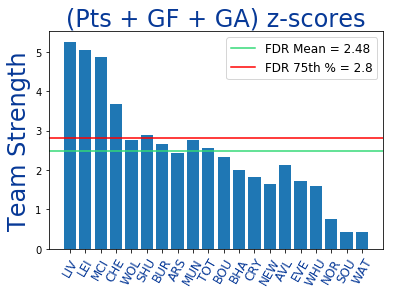

In [22]:
Team = name_list
strength = maybs

mean_FDR = round(np.mean([item for item in maybs]), 2)
FDR_75 = round(np.percentile([item for item in maybs], 75), 2)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GF + GA) z-scores', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

In [23]:
# import plotly.graph_objs as go


# fig = go.Figure([go.Bar(x=Team, y=strength, marker = {'color': '#82DFF1'})])
# fig.add_trace(go.Scatter(
#     x=['LIV', 'WAT'],
#     y=[mean_FDR, mean_FDR],
#     mode="lines",
# ))

# fig.layout.plot_bgcolor = '#082391'                
# fig.update_layout(
#     title='US Export of Plastic Scrap',
#     xaxis_tickfont_size=14,
#     yaxis=dict(
#         title='USD (millions)',
#         showgrid=False,
#         titlefont_size=16,
#         tickfont_size=14,
#     ))

# fig.write_image('figure.png')
# fig.show()

In [24]:
zipped_list = list(zip(name_list, pts_list, GF_list, GA_list))

In [25]:
zipped_list[:3]

[('LIV', 37, 30, 11), ('LEI', 29, 31, 8), ('MCI', 28, 37, 14)]

In [26]:
def get_percentiles(zipped_list):
    listy = []
    for item in zipped_list:
        team = item[0]
        pts_perc = stats.percentileofscore(pts_list, item[1])
        GF_perc = stats.percentileofscore(GF_list, item[2])
        GA_perc = stats.percentileofscore(GA_list, item[3])
        FDR = pts_perc + GF_perc + (100-GA_perc)
        tup = (team, FDR)
        listy.append(tup)
    return listy
    

In [27]:
FDR_new = get_percentiles(zipped_list)

In [28]:
FDR_new

[('LIV', 280.0),
 ('LEI', 285.0),
 ('MCI', 270.0),
 ('CHE', 212.5),
 ('WOL', 207.5),
 ('SHU', 200.0),
 ('BUR', 202.5),
 ('ARS', 170.0),
 ('MUN', 200.0),
 ('TOT', 180.0),
 ('BOU', 160.0),
 ('BHA', 117.5),
 ('CRY', 110.0),
 ('NEW', 77.5),
 ('AVL', 120.0),
 ('EVE', 77.5),
 ('WHU', 80.0),
 ('NOR', 45.0),
 ('SOU', 35.0),
 ('WAT', 20.0)]

In [29]:
mean_FDR = np.mean([item[1] for item in FDR_new])

In [30]:
mean_FDR

152.5

<function matplotlib.pyplot.show(*args, **kw)>

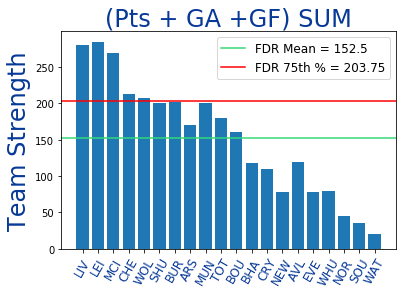

In [31]:
Team = [item[0] for item in FDR_new]
strength = [item[1] for item in FDR_new]

mean_FDR = np.mean([item[1] for item in FDR_new])
FDR_75 = np.percentile([item[1] for item in FDR_new], 75)

plt.bar(Team, strength)
plt.axhline(y=mean_FDR, linestyle='-', color='#33D977', label='FDR Mean = ' + str(mean_FDR))
plt.axhline(y=FDR_75, linestyle='-', color='red', label='FDR 75th % = ' + str(FDR_75))
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('(Pts + GA +GF) SUM', fontsize = 24, color = '#073997')
plt.legend(fontsize = '12')
plt.show

### Function to return percentile for each team

## Add player status and ROI, pts-per-90min metrics to final player_df

In [32]:
def attach_team_and_position(main_players, all_teams, positons):
    players = main_players.copy()
    for team in all_teams:
        for player in players:
            if team['code'] == player['team_code']:
                player['team_name'] = team['name']
    for position in positions:
        for player in players:
            if position['id'] == player['element_type']:
                player['position'] = position['singular_name']
    for player in players:
        if player['status'] == "a":
            player['status'] = "available"
        elif player['status'] == "d":
            player['status'] = "doubtful"
        elif player['status'] == "i":
            player['status'] = "injured"
        elif player['status'] == "s":
            player['status'] = "suspended"
    return players


#### Temporarily took out the "main_players" filter because no players have played 330 minutes ####

# player_positions_teams = attach_team_and_position(main_players, all_teams_new, positions)
player_positions_teams = attach_team_and_position(all_players, all_teams, positions)


def final_players_list(player_positions_teams):
    players = player_positions_teams.copy()
    empty = []
    for player in players:
        stats = dict(team_code = player['team_code'],
        team_name = player['team_name'],
        name = player['first_name'] + " " + player['second_name'],
        status = player['status'],
        position = player['position'],
        cost = (player['now_cost'])/10,
        total_points = player['total_points'],
        roi = round((player['total_points'] / player['now_cost'])*10, 2),
        pts_per_90min = round((player['total_points'] / (player['minutes'] + 1))*90, 2),
        bonus = player['bonus'],
        red_cards = player['red_cards'],
        minutes = player['minutes'],
        transfers_out = player['transfers_out'],
        transfers_in = player['transfers_in'])
        empty.append(stats)
    return empty

In [33]:
final = final_players_list(player_positions_teams)

In [34]:
final[0]

{'team_code': 3,
 'team_name': 'Arsenal',
 'name': 'Shkodran Mustafi',
 'status': 'available',
 'position': 'Defender',
 'cost': 5.2,
 'total_points': 0,
 'roi': 0.0,
 'pts_per_90min': 0.0,
 'bonus': 0,
 'red_cards': 0,
 'minutes': 0,
 'transfers_out': 30389,
 'transfers_in': 7135}

In [35]:
all_teams[0]

{'code': 3,
 'draw': 0,
 'form': None,
 'id': 1,
 'loss': 0,
 'name': 'Arsenal',
 'played': 0,
 'points': 0,
 'position': 0,
 'short_name': 'ARS',
 'strength': 4,
 'team_division': None,
 'unavailable': False,
 'win': 0,
 'strength_overall_home': 1230,
 'strength_overall_away': 1270,
 'strength_attack_home': 1150,
 'strength_attack_away': 1190,
 'strength_defence_home': 1280,
 'strength_defence_away': 1330}

### Get Total ROI, Points and 90min before filtering injured and FDR

In [36]:
total_roi = sorted(final, key = lambda x: x['roi'], reverse = True)

In [37]:
total_roi[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'John Lundstram',
  'status': 'available',
  'position': 'Defender',
  'cost': 5.0,
  'total_points': 73,
  'roi': 14.6,
  'pts_per_90min': 5.77,
  'bonus': 10,
  'red_cards': 0,
  'minutes': 1138,
  'transfers_out': 285888,
  'transfers_in': 2716893},
 {'team_code': 36,
  'team_name': 'Brighton',
  'name': 'Mathew Ryan',
  'status': 'available',
  'position': 'Goalkeeper',
  'cost': 4.7,
  'total_points': 58,
  'roi': 12.34,
  'pts_per_90min': 4.46,
  'bonus': 11,
  'red_cards': 0,
  'minutes': 1170,
  'transfers_out': 435631,
  'transfers_in': 720611}]

### Total_Points

In [38]:
total_max_pts = sorted(total_roi, key = lambda x: x['total_points'], reverse = True)

In [39]:
total_max_pts[:2]

[{'team_code': 13,
  'team_name': 'Leicester',
  'name': 'Jamie Vardy',
  'status': 'available',
  'position': 'Forward',
  'cost': 9.7,
  'total_points': 104,
  'roi': 10.72,
  'pts_per_90min': 7.99,
  'bonus': 19,
  'red_cards': 0,
  'minutes': 1170,
  'transfers_out': 575140,
  'transfers_in': 2712067},
 {'team_code': 14,
  'team_name': 'Liverpool',
  'name': 'Sadio Mané',
  'status': 'available',
  'position': 'Midfielder',
  'cost': 12.2,
  'total_points': 92,
  'roi': 7.54,
  'pts_per_90min': 7.83,
  'bonus': 13,
  'red_cards': 0,
  'minutes': 1056,
  'transfers_out': 784924,
  'transfers_in': 2467099}]

### 90 min

In [40]:
total_90min = sorted(total_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
total_90min = [player for player in total_90min if player['minutes'] >= min_min]

In [41]:
total_90min[:2]

[{'team_code': 49,
  'team_name': 'Sheffield Utd',
  'name': 'Lys Mousset',
  'status': 'doubtful',
  'position': 'Forward',
  'cost': 5.0,
  'total_points': 44,
  'roi': 8.8,
  'pts_per_90min': 9.52,
  'bonus': 6,
  'red_cards': 0,
  'minutes': 415,
  'transfers_out': 68048,
  'transfers_in': 235292},
 {'team_code': 43,
  'team_name': 'Man City',
  'name': 'Riyad Mahrez',
  'status': 'available',
  'position': 'Midfielder',
  'cost': 8.3,
  'total_points': 56,
  'roi': 6.75,
  'pts_per_90min': 9.2,
  'bonus': 9,
  'red_cards': 0,
  'minutes': 547,
  'transfers_out': 774485,
  'transfers_in': 794312}]

### Create Players DataFrame

In [42]:
player_df = pd.DataFrame(final)

In [43]:
player_df.sort_values(by = ['roi'], ascending = False, inplace = True)

In [44]:
player_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
394,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
96,11,4.7,1170,Mathew Ryan,Goalkeeper,4.46,0,12.34,available,36,Brighton,58,720611,435631
224,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
84,7,4.7,1170,Aaron Ramsdale,Goalkeeper,4.15,0,11.49,available,91,Bournemouth,54,355637,68088
126,6,4.7,1170,Nick Pope,Goalkeeper,4.15,0,11.49,available,90,Burnley,54,909912,316352
391,3,4.6,1170,George Baldock,Defender,4.00,0,11.30,available,49,Sheffield Utd,52,202109,41920
117,9,5.0,1170,James Tarkowski,Defender,4.30,0,11.20,available,90,Burnley,56,145361,73212
228,1,5.2,1170,Kasper Schmeichel,Goalkeeper,4.46,0,11.15,available,13,Leicester,58,632622,232508
407,2,4.7,1080,Dean Henderson,Goalkeeper,4.25,0,10.85,available,49,Sheffield Utd,51,416512,166426
226,19,9.7,1170,Jamie Vardy,Forward,7.99,0,10.72,available,13,Leicester,104,2712067,575140


### Merge two team tables s owe have all data

In [45]:
def merged_teams(table_df, all_teams):
    table_dic = table_df.to_dict('records')
    
    for team in table_dic:
        for item in all_teams:
            if team['Team'] == item['short_name']:
                team['code'] = item['code']
                team['name'] = item['name']
                team['strength'] = item['strength']
            
    new_df = pd.DataFrame(table_dic)
    
    new_order = ['code', 'strength', 'Team','name', 'Played', 'W', 'L', 'D', 'GF', 'GA', 'GD', 'Pts']
    
    table_df = new_df[new_order]
    
    table_df.index = np.arange(1, len(table_df) + 1)
    table_df.index.name = 'Position'
    
    return table_df
    

In [46]:
team_df = merged_teams(table_df, all_teams)

In [47]:
team_df.head()

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,13,12,0,1,30,11,+19,37
2,13,4,LEI,Leicester,13,9,2,2,31,8,+23,29
3,43,5,MCI,Man City,13,9,3,1,37,14,+23,28
4,8,4,CHE,Chelsea,13,8,3,2,28,19,+9,26
5,39,3,WOL,Wolves,13,4,2,7,18,16,+2,19


In [48]:
team_names = list(team_df.name)

In [49]:
team_names.sort()

In [50]:
team_names

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

## Create Schedule DF

In [51]:
def extract_sched(schedules):
    dic = {}
    for i, item in enumerate(schedules):
        name = item.partition(team_names[i])[1]
        sche = item.partition(team_names[i])[2]
        sche = sche.split()
        clean = [item for item in sche if item != "(A)"]
        clean2 = [item for item in clean if item != "(H)"]
        dic[name] = clean2
    return dic

In [52]:
wonders = extract_sched(schedules)

In [53]:
schedule_df = pd.DataFrame(wonders)

In [54]:
schedule_df.index.name = 'Gameweek'

In [55]:
schedule_df.head()

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE


In [56]:
schedule_df.Arsenal[0:3]

Gameweek
0    NEW
1    BUR
2    LIV
Name: Arsenal, dtype: object

## Create FDR scores for calculating next-n opponents AVG strength

In [57]:
scores = list(zip(team_df.Team, team_df.strength))

In [58]:
scores = dict(scores)

In [59]:
sorted(scores.items(), key = lambda x: x[1], reverse = True)

[('LIV', 5),
 ('MCI', 5),
 ('LEI', 4),
 ('CHE', 4),
 ('ARS', 4),
 ('MUN', 4),
 ('TOT', 4),
 ('WOL', 3),
 ('SHU', 3),
 ('BUR', 3),
 ('BOU', 3),
 ('BHA', 3),
 ('CRY', 3),
 ('NEW', 3),
 ('EVE', 3),
 ('WHU', 3),
 ('WAT', 3),
 ('AVL', 2),
 ('NOR', 2),
 ('SOU', 2)]

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

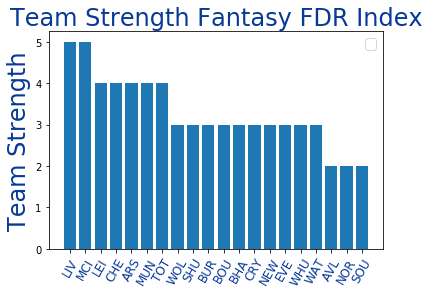

In [60]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 6

sorted_data = sorted(scores.items(), key = lambda x: x[1], reverse = True)

Team = [item[0] for item in sorted_data]
strength = [item[1] for item in sorted_data]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength Fantasy FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [61]:
maybs

[5.256371814092954,
 5.0344827586206895,
 4.857571214392803,
 3.664167916041979,
 2.7526236881559223,
 2.893553223388306,
 2.6476761619190405,
 2.4227886056971517,
 2.770614692653673,
 2.5607196401799097,
 2.320839580209895,
 2.008995502248876,
 1.820089955022489,
 1.646176911544228,
 2.128935532233883,
 1.7151424287856072,
 1.5922038980509745,
 0.7436281859070464,
 0.4137931034482759,
 0.43478260869565233]

In [62]:
new_FDR =  list(zip(name_list, maybs))

In [63]:
new_FDR

[('LIV', 5.256371814092954),
 ('LEI', 5.0344827586206895),
 ('MCI', 4.857571214392803),
 ('CHE', 3.664167916041979),
 ('WOL', 2.7526236881559223),
 ('SHU', 2.893553223388306),
 ('BUR', 2.6476761619190405),
 ('ARS', 2.4227886056971517),
 ('MUN', 2.770614692653673),
 ('TOT', 2.5607196401799097),
 ('BOU', 2.320839580209895),
 ('BHA', 2.008995502248876),
 ('CRY', 1.820089955022489),
 ('NEW', 1.646176911544228),
 ('AVL', 2.128935532233883),
 ('EVE', 1.7151424287856072),
 ('WHU', 1.5922038980509745),
 ('NOR', 0.7436281859070464),
 ('SOU', 0.4137931034482759),
 ('WAT', 0.43478260869565233)]

In [64]:
def get_avg_FDR(sorted_data, new_FDR):
    listy = []
    for item in sorted_data:
        for score in new_FDR:
            if item[0] == score[0]:
                team = item[0]
                avg_FDR = np.round((item[1] + score[1])/2, 2)
                tup = (team, avg_FDR)
                listy.append(tup)
    return listy
    

In [65]:
final_avg_FDR = get_avg_FDR(sorted_data, new_FDR)

In [66]:
final_avg_FDR = sorted(final_avg_FDR, key = lambda x: x[1], reverse = True)
final_avg_FDR

[('LIV', 5.13),
 ('MCI', 4.93),
 ('LEI', 4.52),
 ('CHE', 3.83),
 ('MUN', 3.39),
 ('TOT', 3.28),
 ('ARS', 3.21),
 ('SHU', 2.95),
 ('WOL', 2.88),
 ('BUR', 2.82),
 ('BOU', 2.66),
 ('BHA', 2.5),
 ('CRY', 2.41),
 ('EVE', 2.36),
 ('NEW', 2.32),
 ('WHU', 2.3),
 ('AVL', 2.06),
 ('WAT', 1.72),
 ('NOR', 1.37),
 ('SOU', 1.21)]

In [67]:
adjusted_FDR = dict(final_avg_FDR)

In [68]:
adjusted_FDR

{'LIV': 5.13,
 'MCI': 4.93,
 'LEI': 4.52,
 'CHE': 3.83,
 'MUN': 3.39,
 'TOT': 3.28,
 'ARS': 3.21,
 'SHU': 2.95,
 'WOL': 2.88,
 'BUR': 2.82,
 'BOU': 2.66,
 'BHA': 2.5,
 'CRY': 2.41,
 'EVE': 2.36,
 'NEW': 2.32,
 'WHU': 2.3,
 'AVL': 2.06,
 'WAT': 1.72,
 'NOR': 1.37,
 'SOU': 1.21}

No handles with labels found to put in legend.


<function matplotlib.pyplot.show(*args, **kw)>

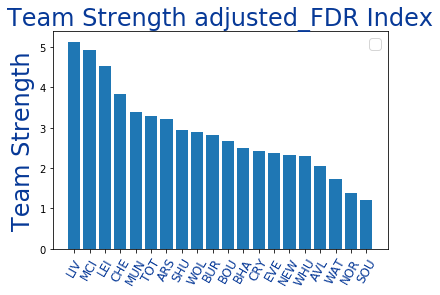

In [69]:
Team = [item[0] for item in final_avg_FDR]
strength = [item[1] for item in final_avg_FDR]

plt.bar(Team, strength)
plt.ylabel('Team Strength', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Team Strength adjusted_FDR Index', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

In [70]:
schedule_df.columns

Index(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brighton', 'Burnley',
       'Chelsea', 'Crystal Palace', 'Everton', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Watford', 'West Ham', 'Wolves'],
      dtype='object')

In [71]:
schedule_df.head(10)

,Arsenal,Aston Villa,Bournemouth,Brighton,Burnley,Chelsea,Crystal Palace,Everton,Leicester,Liverpool,Man City,Man Utd,Newcastle,Norwich,Sheffield Utd,Southampton,Spurs,Watford,West Ham,Wolves
Gameweek,,,,,,,,,,,,,,,,,,,,
0,NEW,TOT,SHU,WAT,SOU,MUN,EVE,CRY,WOL,NOR,WHU,CHE,ARS,LIV,BOU,BUR,AVL,BHA,MCI,LEI
1,BUR,BOU,AVL,WHU,ARS,LEI,SHU,WAT,CHE,SOU,TOT,WOL,NOR,NEW,CRY,LIV,MCI,EVE,BHA,MUN
2,LIV,EVE,MCI,SOU,WOL,NOR,MUN,AVL,SHU,ARS,BOU,CRY,TOT,CHE,LEI,BHA,NEW,WHU,WAT,BUR
3,TOT,CRY,LEI,MCI,LIV,SHU,AVL,WOL,BOU,BUR,BHA,SOU,WAT,WHU,CHE,MUN,ARS,NEW,NOR,EVE
4,WAT,WHU,EVE,BUR,BHA,WOL,TOT,BOU,MUN,NEW,NOR,LEI,LIV,MCI,SOU,SHU,CRY,ARS,AVL,CHE
5,AVL,ARS,SOU,NEW,NOR,LIV,WOL,SHU,TOT,CHE,WAT,WHU,BHA,BUR,EVE,BOU,LEI,MCI,MUN,CRY
6,MUN,BUR,WHU,CHE,AVL,BHA,NOR,MCI,NEW,SHU,EVE,ARS,LEI,CRY,LIV,TOT,SOU,WOL,BOU,WAT
7,BOU,NOR,ARS,TOT,EVE,SOU,WHU,BUR,LIV,LEI,WOL,NEW,MUN,AVL,WAT,CHE,BHA,SHU,CRY,MCI
8,SHU,BHA,NOR,AVL,LEI,NEW,MCI,WHU,BUR,MUN,CRY,LIV,CHE,BOU,ARS,WOL,WAT,TOT,EVE,SOU


In [72]:
def avg_FDR(scores = adjusted_FDR, week = gameweek, periods = next_n_games):
    dic = {}
    for team in schedule_df.columns:
        oponents = schedule_df[team][(week-1):(week+periods)]
        avg_FDR = round(sum([scores[oponent] for oponent in oponents])/len(oponents), 2)
        dic[team] = avg_FDR
    return dic

In [73]:
calculate_FDR = avg_FDR()

In [74]:
sorted_FDR = sorted(calculate_FDR.items(), key=lambda x: x[1], reverse=True)

In [75]:
sorted_FDR

[('Everton', 4.49),
 ('Aston Villa', 3.91),
 ('Brighton', 3.74),
 ('Bournemouth', 3.61),
 ('Burnley', 3.54),
 ('Man Utd', 3.42),
 ('West Ham', 3.31),
 ('Newcastle', 3.03),
 ('Spurs', 2.96),
 ('Man City', 2.84),
 ('Watford', 2.71),
 ('Wolves', 2.58),
 ('Liverpool', 2.51),
 ('Norwich', 2.46),
 ('Crystal Palace', 2.4),
 ('Chelsea', 2.24),
 ('Sheffield Utd', 2.19),
 ('Arsenal', 2.06),
 ('Leicester', 2.05),
 ('Southampton', 1.8)]

<function matplotlib.pyplot.show(*args, **kw)>

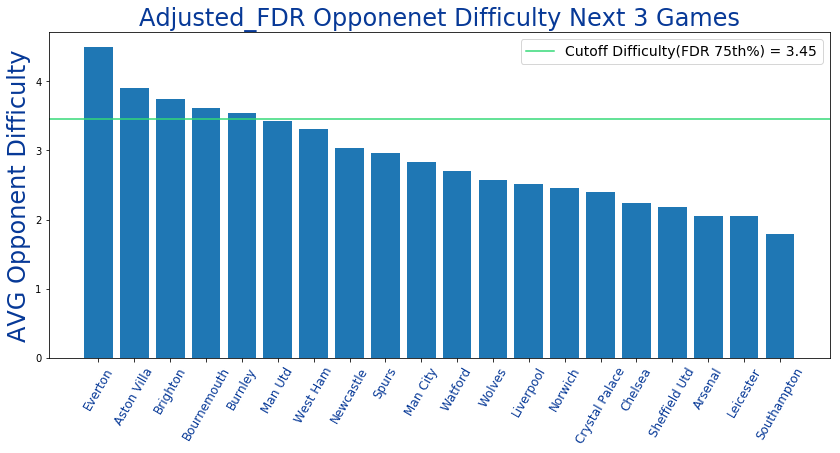

In [76]:
rcParams['figure.figsize'] = 14, 6

Team = [item[0] for item in sorted_FDR]
FDR = [item[1] for item in sorted_FDR]

FDR_75 = round(np.percentile([item[1] for item in sorted_FDR], 75), 2)
cutoff = FDR_75

plt.bar(Team, FDR)
plt.axhline(y=cutoff, linestyle='-', color='#33D977', label='Cutoff Difficulty(FDR 75th%) = ' + str(cutoff))
plt.ylabel('AVG Opponent Difficulty', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Adjusted_FDR Opponenet Difficulty Next ' + str(next_n_games +1) + ' Games', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('FDR', bbox_inches = 'tight')
plt.show

## Clean final list of available players by FDR score <= 3.56 and status = 'available'

In [77]:
player_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
394,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
96,11,4.7,1170,Mathew Ryan,Goalkeeper,4.46,0,12.34,available,36,Brighton,58,720611,435631
224,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
84,7,4.7,1170,Aaron Ramsdale,Goalkeeper,4.15,0,11.49,available,91,Bournemouth,54,355637,68088
126,6,4.7,1170,Nick Pope,Goalkeeper,4.15,0,11.49,available,90,Burnley,54,909912,316352


In [78]:
player_df.shape

(560, 14)

In [79]:
clean_df = player_df[player_df.status == 'available']

In [80]:
clean_df.status.value_counts()

available    423
Name: status, dtype: int64

## Remove teams with FDR scores > 3.56 from DF - optional

In [81]:
teams_low_FDR = [key for (key,value) in calculate_FDR.items() if value <= cutoff]

In [82]:
teams_low_FDR

['Arsenal',
 'Chelsea',
 'Crystal Palace',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man Utd',
 'Newcastle',
 'Norwich',
 'Sheffield Utd',
 'Southampton',
 'Spurs',
 'Watford',
 'West Ham',
 'Wolves']

In [83]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
394,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
96,11,4.7,1170,Mathew Ryan,Goalkeeper,4.46,0,12.34,available,36,Brighton,58,720611,435631
224,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
84,7,4.7,1170,Aaron Ramsdale,Goalkeeper,4.15,0,11.49,available,91,Bournemouth,54,355637,68088
126,6,4.7,1170,Nick Pope,Goalkeeper,4.15,0,11.49,available,90,Burnley,54,909912,316352


In [84]:
final_df = clean_df.loc[clean_df.team_name.isin(teams_low_FDR)]

In [85]:
final_df.head(15)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
394,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
224,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
391,3,4.6,1170,George Baldock,Defender,4.00,0,11.30,available,49,Sheffield Utd,52,202109,41920
228,1,5.2,1170,Kasper Schmeichel,Goalkeeper,4.46,0,11.15,available,13,Leicester,58,632622,232508
407,2,4.7,1080,Dean Henderson,Goalkeeper,4.25,0,10.85,available,49,Sheffield Utd,51,416512,166426
226,19,9.7,1170,Jamie Vardy,Forward,7.99,0,10.72,available,13,Leicester,104,2712067,575140
221,3,5.8,990,Benjamin Chilwell,Defender,5.63,0,10.69,available,13,Leicester,62,864275,259104
367,6,4.5,990,Tim Krul,Goalkeeper,4.36,0,10.67,available,45,Norwich,48,97981,73184
220,7,6.4,1170,Ricardo Domingos Barbosa Pereira,Defender,5.23,0,10.62,available,13,Leicester,68,964375,326153
390,4,4.6,1170,Jack O'Connell,Defender,3.69,0,10.43,available,49,Sheffield Utd,48,148226,42899


In [86]:
clean_players = final_df.to_dict('records')

In [87]:
clean_players[:2]

[{'bonus': 10,
  'cost': 5.0,
  'minutes': 1138,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.77,
  'red_cards': 0,
  'roi': 14.6,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 73,
  'transfers_in': 2716893,
  'transfers_out': 285888},
 {'bonus': 5,
  'cost': 5.0,
  'minutes': 1170,
  'name': 'Çaglar Söyüncü',
  'position': 'Defender',
  'pts_per_90min': 4.69,
  'red_cards': 0,
  'roi': 12.2,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 61,
  'transfers_in': 1292456,
  'transfers_out': 201466}]

## Get list of players by ROI, Total Points and Points Per 90 min

In [88]:
players_roi = sorted(clean_players, key = lambda x: x['roi'], reverse = True)

In [89]:
players_roi[:3]

[{'bonus': 10,
  'cost': 5.0,
  'minutes': 1138,
  'name': 'John Lundstram',
  'position': 'Defender',
  'pts_per_90min': 5.77,
  'red_cards': 0,
  'roi': 14.6,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 73,
  'transfers_in': 2716893,
  'transfers_out': 285888},
 {'bonus': 5,
  'cost': 5.0,
  'minutes': 1170,
  'name': 'Çaglar Söyüncü',
  'position': 'Defender',
  'pts_per_90min': 4.69,
  'red_cards': 0,
  'roi': 12.2,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 61,
  'transfers_in': 1292456,
  'transfers_out': 201466},
 {'bonus': 3,
  'cost': 4.6,
  'minutes': 1170,
  'name': 'George Baldock',
  'position': 'Defender',
  'pts_per_90min': 4.0,
  'red_cards': 0,
  'roi': 11.3,
  'status': 'available',
  'team_code': 49,
  'team_name': 'Sheffield Utd',
  'total_points': 52,
  'transfers_in': 202109,
  'transfers_out': 41920}]

### Total Points

In [90]:
players_max_pts = sorted(players_roi, key = lambda x: x['total_points'], reverse = True)

In [91]:
players_max_pts[:3]

[{'bonus': 19,
  'cost': 9.7,
  'minutes': 1170,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.99,
  'red_cards': 0,
  'roi': 10.72,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 104,
  'transfers_in': 2712067,
  'transfers_out': 575140},
 {'bonus': 13,
  'cost': 12.2,
  'minutes': 1056,
  'name': 'Sadio Mané',
  'position': 'Midfielder',
  'pts_per_90min': 7.83,
  'red_cards': 0,
  'roi': 7.54,
  'status': 'available',
  'team_code': 14,
  'team_name': 'Liverpool',
  'total_points': 92,
  'transfers_in': 2467099,
  'transfers_out': 784924},
 {'bonus': 10,
  'cost': 10.2,
  'minutes': 963,
  'name': 'Kevin De Bruyne',
  'position': 'Midfielder',
  'pts_per_90min': 7.75,
  'red_cards': 0,
  'roi': 8.14,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 83,
  'transfers_in': 3104362,
  'transfers_out': 1617296}]

### Per 90 mins played

In [92]:
players_90min = sorted(players_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
players_90min = [player for player in players_90min if player['minutes'] >= min_min]

In [93]:
players_90min[:3]

[{'bonus': 9,
  'cost': 8.3,
  'minutes': 547,
  'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'pts_per_90min': 9.2,
  'red_cards': 0,
  'roi': 6.75,
  'status': 'available',
  'team_code': 43,
  'team_name': 'Man City',
  'total_points': 56,
  'transfers_in': 794312,
  'transfers_out': 774485},
 {'bonus': 19,
  'cost': 9.7,
  'minutes': 1170,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.99,
  'red_cards': 0,
  'roi': 10.72,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 104,
  'transfers_in': 2712067,
  'transfers_out': 575140},
 {'bonus': 5,
  'cost': 7.5,
  'minutes': 652,
  'name': 'Christian Pulisic',
  'position': 'Midfielder',
  'pts_per_90min': 7.86,
  'red_cards': 0,
  'roi': 7.6,
  'status': 'available',
  'team_code': 8,
  'team_name': 'Chelsea',
  'total_points': 57,
  'transfers_in': 1053294,
  'transfers_out': 735015}]

### Create player lists by position and metric we want to select by

In [94]:
GK_roi = [item for item in players_roi if item['position'] == 'Goalkeeper']
DF_roi = [item for item in players_roi if item['position'] == 'Defender']
MD_roi = [item for item in players_roi if item['position'] == 'Midfielder']
ST_roi = [item for item in players_roi if item['position'] == 'Forward']

In [95]:
GK_pts = [item for item in players_max_pts if item['position'] == 'Goalkeeper']
DF_pts = [item for item in players_max_pts if item['position'] == 'Defender']
MD_pts = [item for item in players_max_pts if item['position'] == 'Midfielder']
ST_pts = [item for item in players_max_pts if item['position'] == 'Forward']

In [96]:
GK_90min = [item for item in players_90min if item['position'] == 'Goalkeeper']
DF_90min = [item for item in players_90min if item['position'] == 'Defender']
MD_90min = [item for item in players_90min if item['position'] == 'Midfielder']
ST_90min = [item for item in players_90min if item['position'] == 'Forward']

## Start by selecting top GKs by ROI

In [97]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_roi:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))

print(players_selected)
print(teams_selected)

9.5
Player Selected: Kasper Schmeichel
GK budget left: 4.3
Player Selected: Adrián San Miguel del Castillo
GK budget left: 0.09999999999999964
['Kasper Schmeichel', 'Adrián San Miguel del Castillo']
['Leicester', 'Liverpool']


## Select Top player by points from DF, MD, ST

In [98]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.599999999999994 36.0 26.0
Player Selected: John Lundstram
DF budget left: 23.599999999999994
Player Selected: Sadio Mané
MD budget left: 23.8
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool']


In [99]:
ST_pts[:3]

[{'bonus': 19,
  'cost': 9.7,
  'minutes': 1170,
  'name': 'Jamie Vardy',
  'position': 'Forward',
  'pts_per_90min': 7.99,
  'red_cards': 0,
  'roi': 10.72,
  'status': 'available',
  'team_code': 13,
  'team_name': 'Leicester',
  'total_points': 104,
  'transfers_in': 2712067,
  'transfers_out': 575140},
 {'bonus': 14,
  'cost': 8.6,
  'minutes': 1126,
  'name': 'Marcus Rashford',
  'position': 'Forward',
  'pts_per_90min': 5.91,
  'red_cards': 0,
  'roi': 8.6,
  'status': 'available',
  'team_code': 1,
  'team_name': 'Man Utd',
  'total_points': 74,
  'transfers_in': 1325389,
  'transfers_out': 1603209},
 {'bonus': 12,
  'cost': 11.0,
  'minutes': 1170,
  'name': 'Pierre-Emerick Aubameyang',
  'position': 'Forward',
  'pts_per_90min': 5.69,
  'red_cards': 0,
  'roi': 6.73,
  'status': 'available',
  'team_code': 3,
  'team_name': 'Arsenal',
  'total_points': 74,
  'transfers_in': 1276963,
  'transfers_out': 1500593}]

In [100]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Jamie Vardy
ST budget left: 16.3
5
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester']


In [101]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [102]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with top ROI players

In [103]:
for item in DF_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
        print('# of DFs selected: ' + str(DF_curr))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected)                       

Player Selected: Çaglar Söyüncü
DF budget left: 18.599999999999994
# of DFs selected: 2
Player Selected: George Baldock
DF budget left: 13.999999999999995
# of DFs selected: 3
Player Selected: Jack O'Connell
DF budget left: 9.399999999999995
# of DFs selected: 4
Player Selected: Jetro Willems
DF budget left: 4.799999999999995
# of DFs selected: 5
9
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Çaglar Söyüncü', 'George Baldock', "Jack O'Connell", 'Jetro Willems']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Leicester', 'Sheffield Utd', 'Sheffield Utd', 'Newcastle']


## Fill MD position

In [104]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Adama Traoré
MD budget left: 23.399999999999995
Player Selected: Mason Mount
MD budget left: 16.699999999999996
Player Selected: João Filipe Iria Santos Moutinho
MD budget left: 11.399999999999995
Player Selected: David Silva
MD budget left: 3.7999999999999954
13
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Çaglar Söyüncü', 'George Baldock', "Jack O'Connell", 'Jetro Willems', 'Adama Traoré', 'Mason Mount', 'João Filipe Iria Santos Moutinho', 'David Silva']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Leicester', 'Sheffield Utd', 'Sheffield Utd', 'Newcastle', 'Wolves', 'Chelsea', 'Wolves', 'Man City']


## Fill ST position

In [105]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_roi:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Teemu Pukki
ST budget left: 13.499999999999995
Player Selected: Danny Ings
ST budget left: 7.499999999999995
15
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Çaglar Söyüncü', 'George Baldock', "Jack O'Connell", 'Jetro Willems', 'Adama Traoré', 'Mason Mount', 'João Filipe Iria Santos Moutinho', 'David Silva', 'Teemu Pukki', 'Danny Ings']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Leicester', 'Sheffield Utd', 'Sheffield Utd', 'Newcastle', 'Wolves', 'Chelsea', 'Wolves', 'Man City', 'Norwich', 'Southampton']


In [106]:
money_df = pd.DataFrame(money_team)

In [107]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,1,5.2,1170,Kasper Schmeichel,Goalkeeper,4.46,0,11.15,available,13,Leicester,58,632622,232508
1,0,4.2,681,Adrián San Miguel del Castillo,Goalkeeper,3.04,0,5.48,available,14,Liverpool,23,579696,500653
2,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
3,13,12.2,1056,Sadio Mané,Midfielder,7.83,0,7.54,available,14,Liverpool,92,2467099,784924
4,19,9.7,1170,Jamie Vardy,Forward,7.99,0,10.72,available,13,Leicester,104,2712067,575140
5,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
6,3,4.6,1170,George Baldock,Defender,4.00,0,11.30,available,49,Sheffield Utd,52,202109,41920
7,4,4.6,1170,Jack O'Connell,Defender,3.69,0,10.43,available,49,Sheffield Utd,48,148226,42899
8,6,4.6,833,Jetro Willems,Defender,4.64,0,9.35,available,4,Newcastle,43,163222,44876
9,6,5.2,920,Adama Traoré,Midfielder,4.69,0,9.23,available,39,Wolves,48,432073,163844


<function matplotlib.pyplot.show(*args, **kw)>

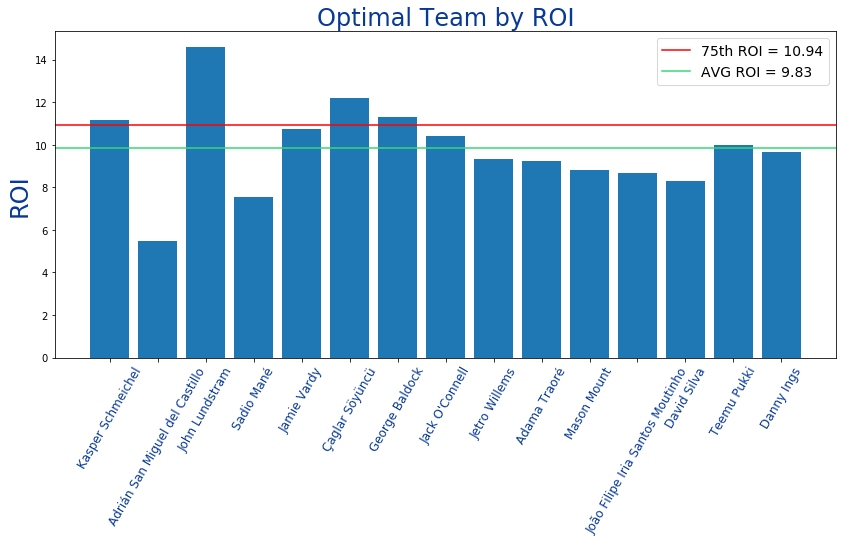

In [108]:
money_x = money_df.roi
money_y = money_df.name
ST_75th = round(money_df.describe().roi['75%'], 2)
ST_AVG = round(money_df.describe().roi['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.show

### Top 10 ROI players by position

In [109]:
GK_df = pd.DataFrame(GK_roi)
GK_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,1,5.2,1170,Kasper Schmeichel,Goalkeeper,4.46,0,11.15,available,13,Leicester,58,632622,232508
1,2,4.7,1080,Dean Henderson,Goalkeeper,4.25,0,10.85,available,49,Sheffield Utd,51,416512,166426
2,6,4.5,990,Tim Krul,Goalkeeper,4.36,0,10.67,available,45,Norwich,48,97981,73184
3,4,5.2,1170,Rui Pedro dos Santos Patrício,Goalkeeper,3.92,0,9.81,available,39,Wolves,51,762035,356974
4,10,4.8,1170,Ben Foster,Goalkeeper,3.61,0,9.79,available,57,Watford,47,73400,115369
5,3,5.0,1170,Bernd Leno,Goalkeeper,3.46,0,9.00,available,3,Arsenal,45,324413,319036
6,1,5.0,1170,Martin Dubravka,Goalkeeper,3.30,0,8.60,available,4,Newcastle,43,40012,45604
7,5,5.5,1170,David de Gea,Goalkeeper,3.38,0,8.00,available,1,Man Utd,44,789431,832904
8,2,6.0,1080,Ederson Santana de Moraes,Goalkeeper,3.91,0,7.83,available,43,Man City,47,772183,1039528
9,2,5.0,990,Vicente Guaita,Goalkeeper,3.18,0,7.00,available,31,Crystal Palace,35,49290,47784


In [110]:
DF_df = pd.DataFrame(DF_roi)
DF_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
1,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
2,3,4.6,1170,George Baldock,Defender,4.00,0,11.30,available,49,Sheffield Utd,52,202109,41920
3,3,5.8,990,Benjamin Chilwell,Defender,5.63,0,10.69,available,13,Leicester,62,864275,259104
4,7,6.4,1170,Ricardo Domingos Barbosa Pereira,Defender,5.23,0,10.62,available,13,Leicester,68,964375,326153
5,4,4.6,1170,Jack O'Connell,Defender,3.69,0,10.43,available,49,Sheffield Utd,48,148226,42899
6,4,5.1,1170,Enda Stevens,Defender,4.00,0,10.20,available,49,Sheffield Utd,52,193806,59635
7,6,4.6,833,Jetro Willems,Defender,4.64,0,9.35,available,4,Newcastle,43,163222,44876
8,1,4.5,1126,Chris Basham,Defender,3.35,0,9.33,available,49,Sheffield Utd,42,23153,9580
9,8,7.0,1170,Andrew Robertson,Defender,4.84,0,9.00,available,14,Liverpool,63,641132,1204273


In [111]:
MD_df = pd.DataFrame(MD_roi)
MD_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,6,5.2,920,Adama Traoré,Midfielder,4.69,0,9.23,available,39,Wolves,48,432073,163844
1,4,6.7,1161,Youri Tielemans,Midfielder,4.65,0,8.96,available,13,Leicester,60,754910,384453
2,6,6.7,1054,Mason Mount,Midfielder,5.03,0,8.81,available,8,Chelsea,59,3270325,1348148
3,2,6.2,770,Ayoze Pérez,Midfielder,6.30,0,8.71,available,13,Leicester,54,444270,960298
4,7,5.3,1079,João Filipe Iria Santos Moutinho,Midfielder,3.83,0,8.68,available,39,Wolves,46,222022,372008
5,8,7.6,1052,James Maddison,Midfielder,5.56,0,8.55,available,13,Leicester,65,1664906,665241
6,3,5.0,1080,Wilfred Ndidi,Midfielder,3.50,0,8.40,available,13,Leicester,42,339346,246901
7,7,7.6,761,David Silva,Midfielder,7.44,0,8.29,available,43,Man City,63,1122673,946308
8,10,10.2,963,Kevin De Bruyne,Midfielder,7.75,0,8.14,available,43,Man City,83,3104362,1617296
9,4,4.8,928,John Fleck,Midfielder,3.78,0,8.12,available,49,Sheffield Utd,39,53338,13899


In [112]:
ST_df = pd.DataFrame(ST_roi)
ST_df.head(10)

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,19,9.7,1170,Jamie Vardy,Forward,7.99,0,10.72,available,13,Leicester,104,2712067,575140
1,9,6.6,1155,Teemu Pukki,Forward,5.14,0,10.00,available,45,Norwich,66,3305769,2603152
2,10,6.0,821,Danny Ings,Forward,6.35,0,9.67,available,20,Southampton,58,382312,256108
3,11,5.1,951,Jordan Ayew,Forward,4.54,0,9.41,available,31,Crystal Palace,48,906139,603150
4,14,7.5,1122,Raúl Jiménez,Forward,5.45,0,9.07,available,39,Wolves,68,948516,1242174
5,14,8.6,1126,Marcus Rashford,Forward,5.91,0,8.60,available,1,Man Utd,74,1325389,1603209
6,5,7.2,1080,Sébastien Haller,Forward,4.16,0,6.94,available,21,West Ham,50,531316,606273
7,12,9.4,1086,Roberto Firmino,Forward,5.38,0,6.91,available,14,Liverpool,65,738435,841540
8,12,11.0,1170,Pierre-Emerick Aubameyang,Forward,5.69,0,6.73,available,3,Arsenal,74,1276963,1500593
9,6,6.1,871,Gerard Deulofeu,Forward,4.13,0,6.56,available,57,Watford,40,187408,367670


## Define Clean df for graphing purposes

In [113]:
clean_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
394,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
96,11,4.7,1170,Mathew Ryan,Goalkeeper,4.46,0,12.34,available,36,Brighton,58,720611,435631
224,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
84,7,4.7,1170,Aaron Ramsdale,Goalkeeper,4.15,0,11.49,available,91,Bournemouth,54,355637,68088
126,6,4.7,1170,Nick Pope,Goalkeeper,4.15,0,11.49,available,90,Burnley,54,909912,316352


In [114]:
graph_roi = []
for row, player in clean_df.iterrows():
    playa = dict(name = player['name'], position = player.position, team=player.team_name, cost = player.cost, points = player.total_points, minutes = player.minutes, ROI = player.roi, pts_per_90min = player.pts_per_90min)
    graph_roi.append(playa)

In [115]:
graph_roi[:3]

[{'name': 'John Lundstram',
  'position': 'Defender',
  'team': 'Sheffield Utd',
  'cost': 5.0,
  'points': 73,
  'minutes': 1138,
  'ROI': 14.6,
  'pts_per_90min': 5.77},
 {'name': 'Mathew Ryan',
  'position': 'Goalkeeper',
  'team': 'Brighton',
  'cost': 4.7,
  'points': 58,
  'minutes': 1170,
  'ROI': 12.34,
  'pts_per_90min': 4.46},
 {'name': 'Çaglar Söyüncü',
  'position': 'Defender',
  'team': 'Leicester',
  'cost': 5.0,
  'points': 61,
  'minutes': 1170,
  'ROI': 12.2,
  'pts_per_90min': 4.69}]

### Graph by ROI

In [116]:
GK_graph = clean_df[clean_df['position'] == 'Goalkeeper']
DF_graph = clean_df[clean_df['position'] == 'Defender']
MD_graph = clean_df[clean_df['position'] == 'Midfielder']
ST_graph = clean_df[clean_df['position'] == 'Forward']

### Graph by 90_min Stat

In [117]:
sorted_players_90min = sorted(graph_roi, key = lambda x: x['pts_per_90min'], reverse = True)

#define filter of minimum time played
min_min = min_min
sorted_players_90min = [player for player in sorted_players_90min if player['minutes'] >= min_min]

In [118]:
sorted_players_90min[:3]

[{'name': 'Riyad Mahrez',
  'position': 'Midfielder',
  'team': 'Man City',
  'cost': 8.3,
  'points': 56,
  'minutes': 547,
  'ROI': 6.75,
  'pts_per_90min': 9.2},
 {'name': 'Jamie Vardy',
  'position': 'Forward',
  'team': 'Leicester',
  'cost': 9.7,
  'points': 104,
  'minutes': 1170,
  'ROI': 10.72,
  'pts_per_90min': 7.99},
 {'name': 'Christian Pulisic',
  'position': 'Midfielder',
  'team': 'Chelsea',
  'cost': 7.5,
  'points': 57,
  'minutes': 652,
  'ROI': 7.6,
  'pts_per_90min': 7.86}]

In [119]:
df_90min = pd.DataFrame(sorted_players_90min)

In [120]:
df_90min.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
0,6.75,8.3,547,Riyad Mahrez,56,Midfielder,9.20,Man City
1,10.72,9.7,1170,Jamie Vardy,104,Forward,7.99,Leicester
2,7.60,7.5,652,Christian Pulisic,57,Midfielder,7.86,Chelsea
3,7.54,12.2,1056,Sadio Mané,92,Midfielder,7.83,Liverpool
4,8.14,10.2,963,Kevin De Bruyne,83,Midfielder,7.75,Man City


In [121]:
GK_90min_graph = df_90min[df_90min['position'] == 'Goalkeeper']
DF_90min_graph = df_90min[df_90min['position'] == 'Defender']
MD_90min_graph = df_90min[df_90min['position'] == 'Midfielder']
ST_90min_graph = df_90min[df_90min['position'] == 'Forward']

In [122]:
GK_90min_graph.head()

,ROI,cost,minutes,name,points,position,pts_per_90min,team
60,12.34,4.7,1170,Mathew Ryan,58,Goalkeeper,4.46,Brighton
61,11.15,5.2,1170,Kasper Schmeichel,58,Goalkeeper,4.46,Leicester
64,10.67,4.5,990,Tim Krul,48,Goalkeeper,4.36,Norwich
70,10.85,4.7,1080,Dean Henderson,51,Goalkeeper,4.25,Sheffield Utd
74,11.49,4.7,1170,Aaron Ramsdale,54,Goalkeeper,4.15,Bournemouth


In [123]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Top 10 Keepers ROI

<function matplotlib.pyplot.show(*args, **kw)>

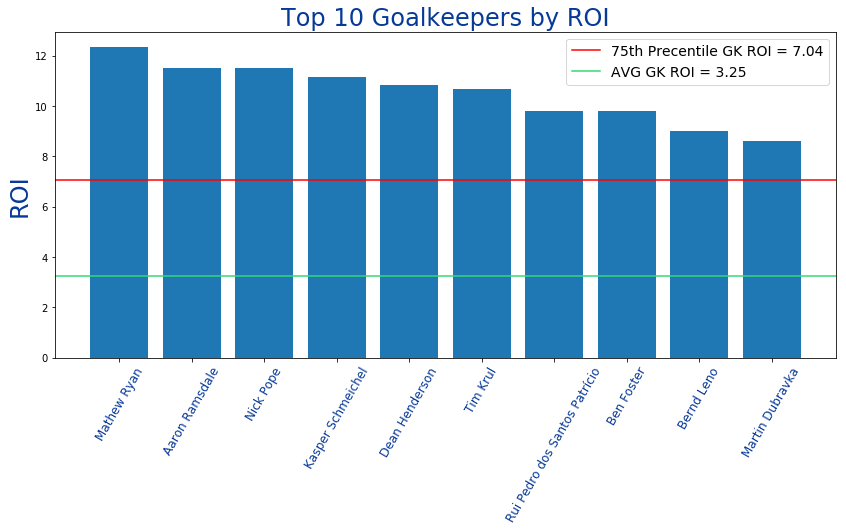

In [124]:
GK_x = GK_graph[:10].roi
GK_y = GK_graph[:10].name
GK_75th = round(GK_graph.describe().roi['75%'], 2)
GK_AVG = round(GK_graph.describe().roi['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK ROI = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK ROI = ' + str(GK_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('GK_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Keepers 90_min

<function matplotlib.pyplot.show(*args, **kw)>

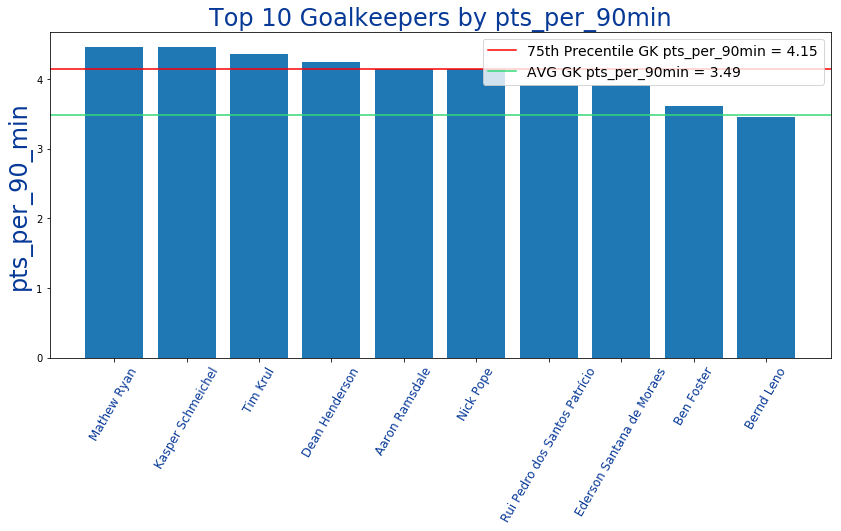

In [125]:
GK_x = GK_90min_graph[:10].pts_per_90min
GK_y = GK_90min_graph[:10].name
GK_75th = round(GK_90min_graph.describe().pts_per_90min['75%'], 2)
GK_AVG = round(GK_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(GK_y, GK_x)
plt.axhline(y=GK_75th, color='r', linestyle='-', label='75th Precentile GK pts_per_90min = ' + str(GK_75th))
plt.axhline(y=GK_AVG, color='#33D977', linestyle='-', label='AVG GK pts_per_90min = ' + str(GK_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Goalkeepers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('GK_90min', bbox_inches = 'tight')
plt.show

## Top 10 Defenders

<function matplotlib.pyplot.show(*args, **kw)>

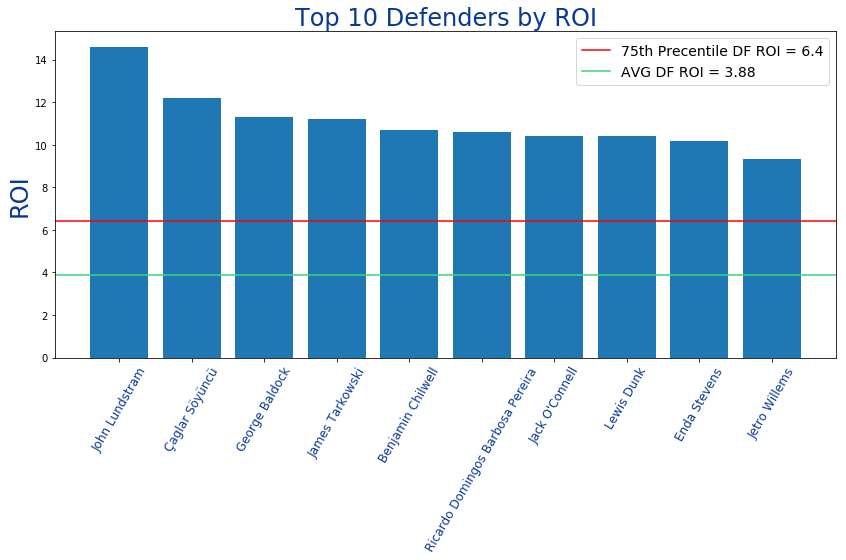

In [126]:
DF_x = DF_graph[:10].roi
DF_y = DF_graph[:10].name
DF_75th = round(DF_graph.describe().roi['75%'], 2)
DF_AVG = round(DF_graph.describe().roi['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF ROI = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF ROI = ' + str(DF_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('DF_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Defenders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

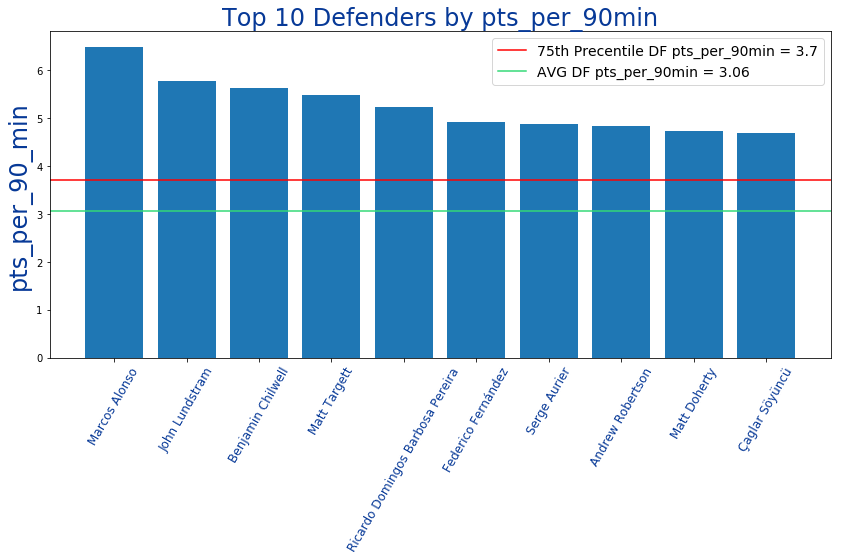

In [127]:
DF_x = DF_90min_graph[:10].pts_per_90min
DF_y = DF_90min_graph[:10].name
DF_75th = round(DF_90min_graph.describe().pts_per_90min['75%'], 2)
DF_AVG = round(DF_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(DF_y, DF_x)
plt.axhline(y=DF_75th, color='r', linestyle='-', label='75th Precentile DF pts_per_90min = ' + str(DF_75th))
plt.axhline(y=DF_AVG, color='#33D977', linestyle='-', label='AVG DF pts_per_90min = ' + str(DF_AVG))
plt.ylabel('pts_per_90_min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Defenders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('DF_90min', bbox_inches = 'tight')
plt.show

## Top 10 Midfielders

<function matplotlib.pyplot.show(*args, **kw)>

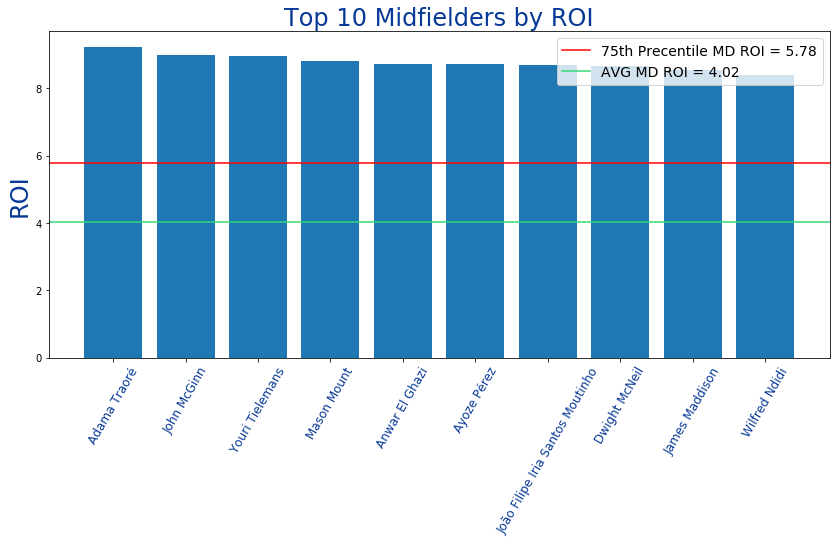

In [128]:
MD_x = MD_graph[:10].roi
MD_y = MD_graph[:10].name
MD_75th = round(MD_graph.describe().roi['75%'], 2)
MD_AVG = round(MD_graph.describe().roi['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD ROI = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD ROI = ' + str(MD_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('MD_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Midfielders 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

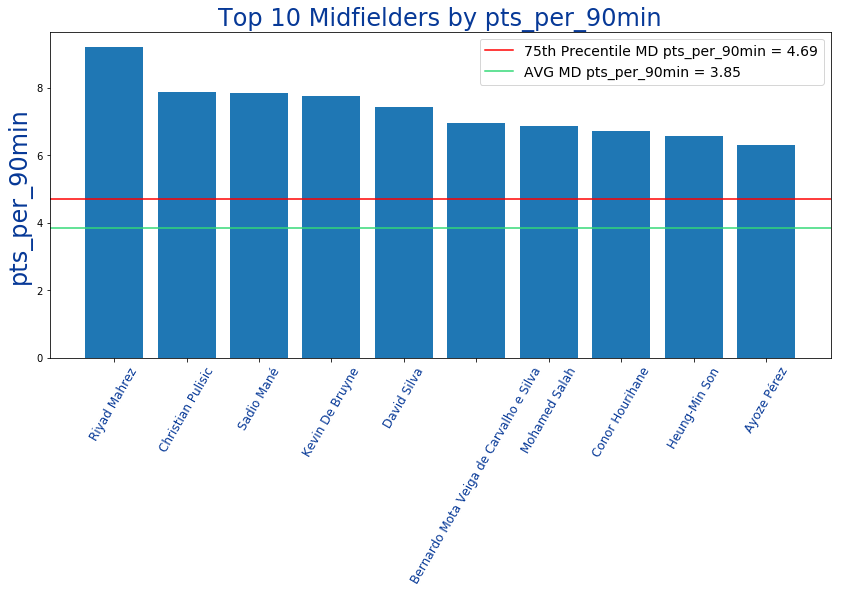

In [129]:
MD_x = MD_90min_graph[:10].pts_per_90min
MD_y = MD_90min_graph[:10].name
MD_75th = round(MD_90min_graph.describe().pts_per_90min['75%'], 2)
MD_AVG = round(MD_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(MD_y, MD_x)
plt.axhline(y=MD_75th, color='r', linestyle='-', label='75th Precentile MD pts_per_90min = ' + str(MD_75th))
plt.axhline(y=MD_AVG, color='#33D977', linestyle='-', label='AVG MD pts_per_90min = ' + str(MD_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Midfielders by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('MD_90min', bbox_inches = 'tight')
plt.show

## Top 10 Strikers

<function matplotlib.pyplot.show(*args, **kw)>

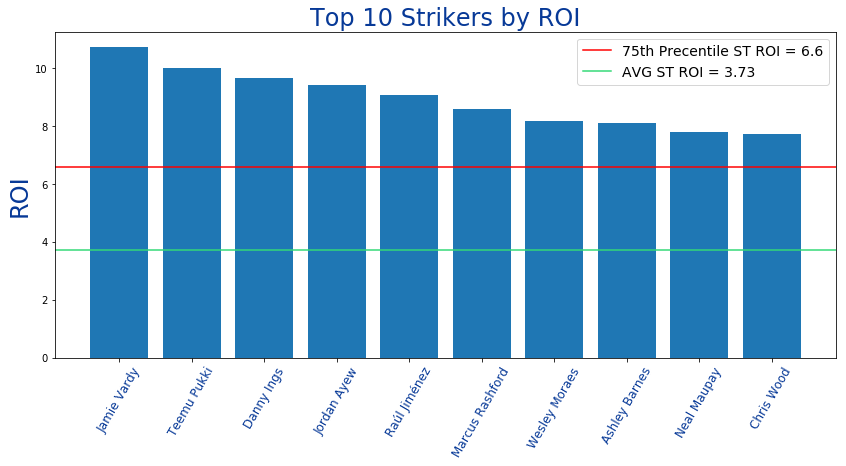

In [130]:
ST_x = ST_graph[:10].roi
ST_y = ST_graph[:10].name
ST_75th = round(ST_graph.describe().roi['75%'], 2)
ST_AVG = round(ST_graph.describe().roi['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST ROI = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST ROI = ' + str(ST_AVG))
plt.ylabel('ROI', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by ROI', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('ST_ROI', bbox_inches = 'tight')
plt.show

## Top 10 Strikers 90min Stat

<function matplotlib.pyplot.show(*args, **kw)>

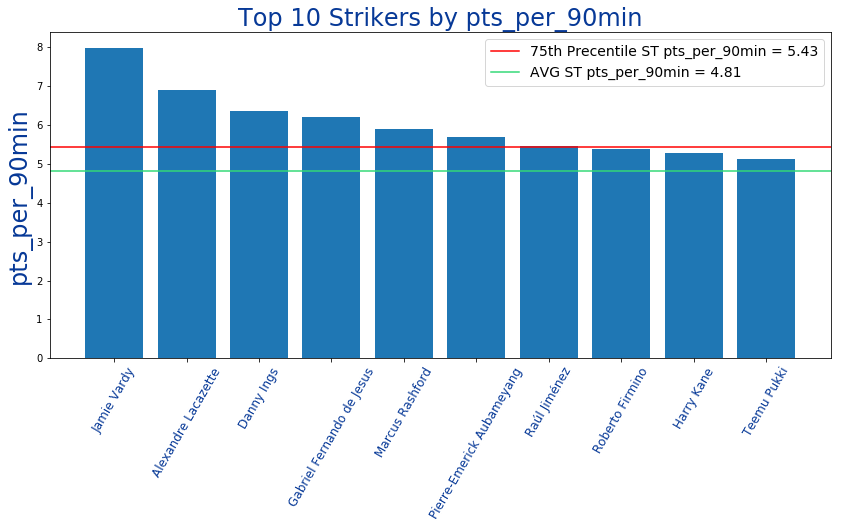

In [131]:
ST_x = ST_90min_graph[:10].pts_per_90min
ST_y = ST_90min_graph[:10].name
ST_75th = round(ST_90min_graph.describe().pts_per_90min['75%'], 2)
ST_AVG = round(ST_90min_graph.describe().pts_per_90min['mean'], 2)

plt.bar(ST_y, ST_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile ST pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG ST pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 10 Strikers by pts_per_90min', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('ST_90min', bbox_inches = 'tight')
plt.show

In [132]:
team_df

,code,strength,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,,,
1,14,5,LIV,Liverpool,13,12,0,1,30,11,+19,37
2,13,4,LEI,Leicester,13,9,2,2,31,8,+23,29
3,43,5,MCI,Man City,13,9,3,1,37,14,+23,28
4,8,4,CHE,Chelsea,13,8,3,2,28,19,+9,26
5,39,3,WOL,Wolves,13,4,2,7,18,16,+2,19
6,49,3,SHU,Sheffield Utd,13,4,3,6,16,12,+4,18
7,90,3,BUR,Burnley,13,5,5,3,20,18,+2,18
8,3,4,ARS,Arsenal,13,4,3,6,18,19,-1,18
9,1,4,MUN,Man Utd,13,4,4,5,19,15,+4,17


### Team Stats

In [133]:
teams_stats = team_df.iloc[:,2:12]

In [134]:
teams_stats.GF = [int(item) for item in teams_stats.GF]
teams_stats.GA = [int(item) for item in teams_stats.GA]

In [135]:
teams_stats

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
1,LIV,Liverpool,13,12,0,1,30,11,+19,37
2,LEI,Leicester,13,9,2,2,31,8,+23,29
3,MCI,Man City,13,9,3,1,37,14,+23,28
4,CHE,Chelsea,13,8,3,2,28,19,+9,26
5,WOL,Wolves,13,4,2,7,18,16,+2,19
6,SHU,Sheffield Utd,13,4,3,6,16,12,+4,18
7,BUR,Burnley,13,5,5,3,20,18,+2,18
8,ARS,Arsenal,13,4,3,6,18,19,-1,18
9,MUN,Man Utd,13,4,4,5,19,15,+4,17


### Worst/ Best  Defence vs. Offence

In [136]:
worst_defence_df = teams_stats.sort_values(by = ['GA'], ascending = False)

In [137]:
worst_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
19,SOU,Southampton,13,2,8,3,13,31,-18,9
18,NOR,Norwich,13,3,9,1,13,28,-15,10
20,WAT,Watford,13,1,7,5,8,26,-18,8
17,WHU,West Ham,13,3,6,4,16,23,-7,13
14,NEW,Newcastle,13,4,6,3,11,20,-9,15


In [138]:
best_defence_df = teams_stats.sort_values(by = ['GA'], ascending = True)

In [139]:
best_defence_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
2,LEI,Leicester,13,9,2,2,31,8,+23,29
1,LIV,Liverpool,13,12,0,1,30,11,+19,37
6,SHU,Sheffield Utd,13,4,3,6,16,12,+4,18
3,MCI,Man City,13,9,3,1,37,14,+23,28
9,MUN,Man Utd,13,4,4,5,19,15,+4,17


In [140]:
GA = list(zip(worst_defence_df.name, worst_defence_df.GA))
GA_bottom5 = GA[:7]
GA_top5 = sorted(GA[-7:], key = lambda x: x[1])

In [141]:
GA_bottom5, GA_top5

([('Southampton', 31),
  ('Norwich', 28),
  ('Watford', 26),
  ('West Ham', 23),
  ('Newcastle', 20),
  ('Everton', 20),
  ('Aston Villa', 20)],
 [('Leicester', 8),
  ('Liverpool', 11),
  ('Sheffield Utd', 12),
  ('Man City', 14),
  ('Man Utd', 15),
  ('Wolves', 16),
  ('Bournemouth', 17)])

In [142]:
teams_stats.GA.median()

19.0

<function matplotlib.pyplot.show(*args, **kw)>

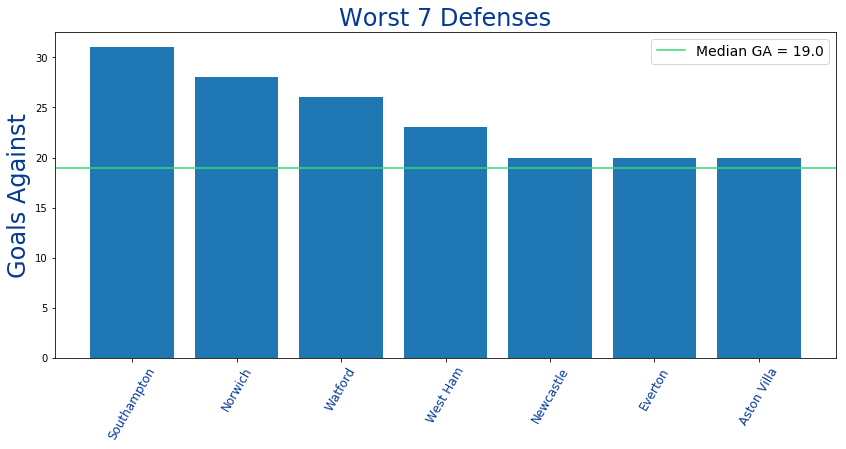

In [143]:
X = [item[0] for item in GA_bottom5]
Y = [int(item[1]) for item in GA_bottom5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Worst_DF', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

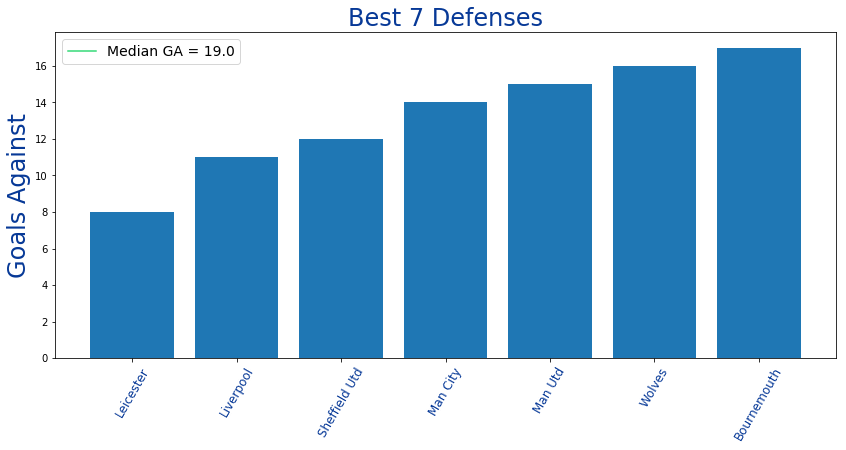

In [144]:
X = [item[0] for item in GA_top5]
Y = [int(item[1]) for item in GA_top5]

median = teams_stats.GA.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GA = ' + str(median))
plt.ylabel('Goals Against', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Defenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Best_DF', bbox_inches = 'tight')
plt.show

In [145]:
offense_df = teams_stats.sort_values(by = ['GF'], ascending = False)

In [146]:
offense_df.head()

,Team,name,Played,W,L,D,GF,GA,GD,Pts
Position,,,,,,,,,,
3,MCI,Man City,13,9,3,1,37,14,+23,28
2,LEI,Leicester,13,9,2,2,31,8,+23,29
1,LIV,Liverpool,13,12,0,1,30,11,+19,37
4,CHE,Chelsea,13,8,3,2,28,19,+9,26
10,TOT,Spurs,13,4,4,5,21,19,+2,17


In [147]:
GF = list(zip(offense_df.name, offense_df.GF))
GF_top5 = GF[:7]
GF_bottom5 = GF[-7:]

In [148]:
GF_top5, GF_bottom5

([('Man City', 37),
  ('Leicester', 31),
  ('Liverpool', 30),
  ('Chelsea', 28),
  ('Spurs', 21),
  ('Burnley', 20),
  ('Aston Villa', 19)],
 [('Brighton', 15),
  ('Everton', 13),
  ('Norwich', 13),
  ('Southampton', 13),
  ('Crystal Palace', 11),
  ('Newcastle', 11),
  ('Watford', 8)])

<function matplotlib.pyplot.show(*args, **kw)>

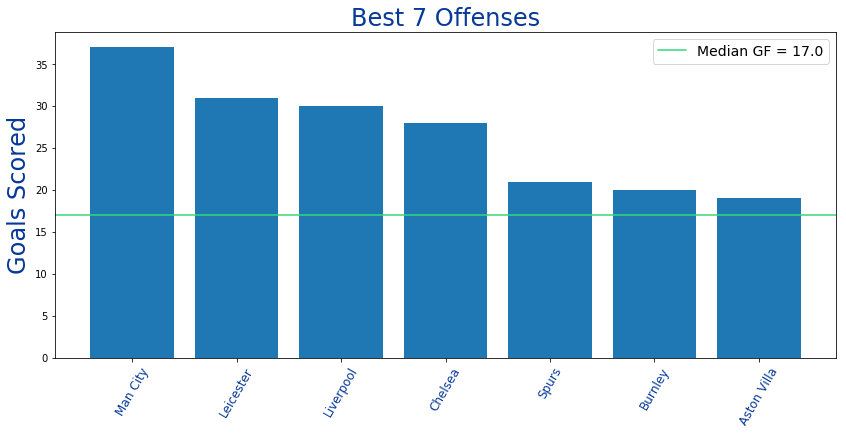

In [149]:
X = [item[0] for item in GF_top5]
Y = [int(item[1]) for item in GF_top5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Best 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Best_Offense', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

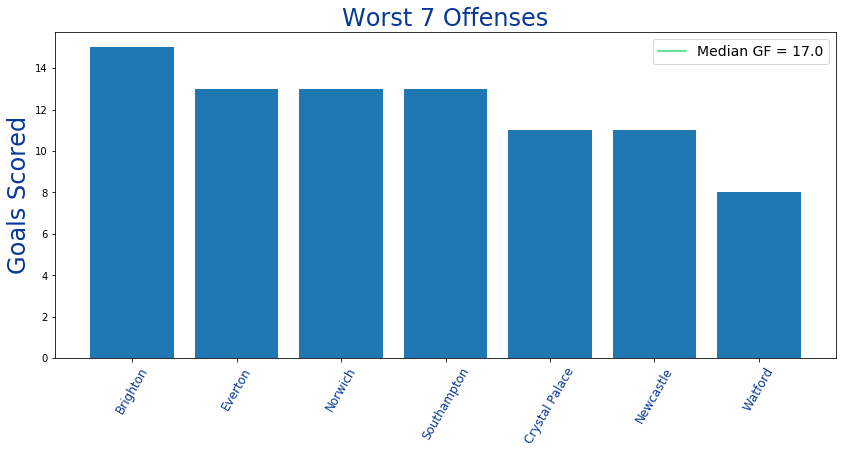

In [150]:
X = [item[0] for item in GF_bottom5]
Y = [int(item[1]) for item in GF_bottom5]

median = teams_stats.GF.median()

plt.bar(X, Y)
plt.ylim(bottom=0)
plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Goals Scored', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Worst 7 Offenses', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Worst_Offense', bbox_inches = 'tight')
plt.show

In [151]:
stats_df = player_df[player_df.minutes >= min_min]

In [152]:
stats_df.tail()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
481,0,4.2,664,Francisco Femenía Far,Defender,0.68,0,1.19,available,57,Watford,5,14544,46944
210,0,5.4,558,Fabian Delph,Defender,0.97,0,1.11,doubtful,11,Everton,6,8792,24493
169,0,5.0,442,James Tomkins,Defender,0.81,0,0.80,available,31,Crystal Palace,4,2139,1584
417,0,4.3,387,Jack Stephens,Defender,0.70,0,0.70,available,20,Southampton,3,1887,5621
414,0,4.8,582,Ryan Bertrand,Defender,0.31,1,0.42,available,20,Southampton,2,9320,53623


### Cobine Team and Player Stats

In [153]:
team_dic = {item:[] for item in team_names}

for row, player in stats_df.iterrows():
    for name in team_names:
        if player.team_name == name:
            playa = dict(name = player['name'], position = player.position, cost = player.cost, minutes = player.minutes, 
                         points = player.total_points,  roi = player.roi, pts_per_90min = player.pts_per_90min, 
                         bonus = player.bonus, red_cards = player.red_cards)
            team_dic[name].append(playa)

In [154]:
stats_df.head()

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
394,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
96,11,4.7,1170,Mathew Ryan,Goalkeeper,4.46,0,12.34,available,36,Brighton,58,720611,435631
224,5,5.0,1170,Çaglar Söyüncü,Defender,4.69,0,12.20,available,13,Leicester,61,1292456,201466
84,7,4.7,1170,Aaron Ramsdale,Goalkeeper,4.15,0,11.49,available,91,Bournemouth,54,355637,68088
126,6,4.7,1170,Nick Pope,Goalkeeper,4.15,0,11.49,available,90,Burnley,54,909912,316352


In [155]:
team_dic['Liverpool']

[{'name': 'Andrew Robertson',
  'position': 'Defender',
  'cost': 7.0,
  'minutes': 1170,
  'points': 63,
  'roi': 9.0,
  'pts_per_90min': 4.84,
  'bonus': 8,
  'red_cards': 0},
 {'name': 'Sadio Mané',
  'position': 'Midfielder',
  'cost': 12.2,
  'minutes': 1056,
  'points': 92,
  'roi': 7.54,
  'pts_per_90min': 7.83,
  'bonus': 13,
  'red_cards': 0},
 {'name': 'Trent Alexander-Arnold',
  'position': 'Defender',
  'cost': 7.2,
  'minutes': 1170,
  'points': 54,
  'roi': 7.5,
  'pts_per_90min': 4.15,
  'bonus': 5,
  'red_cards': 0},
 {'name': 'Roberto Firmino',
  'position': 'Forward',
  'cost': 9.4,
  'minutes': 1086,
  'points': 65,
  'roi': 6.91,
  'pts_per_90min': 5.38,
  'bonus': 12,
  'red_cards': 0},
 {'name': 'Georginio Wijnaldum',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 1079,
  'points': 37,
  'roi': 6.85,
  'pts_per_90min': 3.08,
  'bonus': 2,
  'red_cards': 0},
 {'name': 'Jordan Henderson',
  'position': 'Midfielder',
  'cost': 5.4,
  'minutes': 797,
  'point

### Get Final Stats per Team using Pandas

In [156]:
team_stats = {item:{} for item in team_names}

for team in team_names:
    active_players = len(stats_df[stats_df.team_name == team].cost)
    tot_cost = round(stats_df[stats_df.team_name == team].cost.sum(), 3)
    tot_pts = round(stats_df[stats_df.team_name == team].total_points.sum(), 3)
    avg_player_roi = round(tot_pts / tot_cost, 3)
    avg_pts_per_player = round(tot_pts / active_players, 3)
    
    stats = dict(active_players = active_players, tot_cost = tot_cost, tot_pts = tot_pts,
               avg_pts_per_player = avg_pts_per_player,  avg_player_roi =  avg_player_roi)
    
    team_stats[team].update(stats)
    
    

In [157]:
team_stats['Newcastle']

{'active_players': 16,
 'tot_cost': 77.6,
 'tot_pts': 429,
 'avg_pts_per_player': 26.812,
 'avg_player_roi': 5.528}

In [158]:
team_stats_df = pd.DataFrame(team_stats).T

In [159]:
team_stats_df.sort_values(by = ['avg_pts_per_player'], ascending = False, inplace = True)

In [160]:
team_stats_df

,active_players,avg_player_roi,avg_pts_per_player,tot_cost,tot_pts
Leicester,11.0,9.810,61.182,68.6,673.0
Liverpool,13.0,6.230,43.846,91.5,570.0
Sheffield Utd,13.0,8.641,42.538,64.0,553.0
Man City,16.0,5.746,41.625,115.9,666.0
Burnley,12.0,7.508,39.917,63.8,479.0
Bournemouth,12.0,6.927,37.750,65.4,453.0
Chelsea,14.0,6.367,37.429,82.3,524.0
Wolves,13.0,6.925,37.077,69.6,482.0
Aston Villa,14.0,7.167,35.786,69.9,501.0
Man Utd,13.0,5.377,32.923,79.6,428.0


### Build a team using 90min Stat

In [161]:
#define money team as empty list and list that tracks count of players selectd per team
money_team = []
players_selected = []
teams_selected = []

#Instantiate initial count per position
#Current players selected for each position
DF_curr = 0
MD_curr = 0 
ST_curr = 0

GK_budget = budget*GK_coef
print(GK_budget)

for item in GK_90min:
    if item['cost'] <= 5.5 and item['cost'] <= GK_budget:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        GK_budget -= item['cost']
        print('Player Selected: ' + item['name'])
        print('GK budget left: ' + str(GK_budget))
        
print(players_selected)
print(teams_selected)

9.5
Player Selected: Kasper Schmeichel
GK budget left: 4.3
Player Selected: Adrián San Miguel del Castillo
GK budget left: 0.09999999999999964
['Kasper Schmeichel', 'Adrián San Miguel del Castillo']
['Leicester', 'Liverpool']


### Select top 3 players by points per position

In [162]:
DF_budget = budget*DF_coef + GK_budget
MD_budget = budget*MD_coef
ST_budget = budget*ST_coef

print(DF_budget, MD_budget, ST_budget)

#Select Top Defender
money_team.append(DF_pts[0])
players_selected.append(DF_pts[0]['name'])
teams_selected.append(DF_pts[0]['team_name'])
DF_budget -= DF_pts[0]['cost']
DF_curr += 1
print('Player Selected: ' + DF_pts[0]['name'])
print('DF budget left: ' + str(DF_budget))

#Select Top Midfielder
money_team.append(MD_pts[0])
players_selected.append(MD_pts[0]['name'])
teams_selected.append(MD_pts[0]['team_name'])
MD_budget -= MD_pts[0]['cost']
MD_curr += 1
print('Player Selected: ' + MD_pts[0]['name'])
print('MD budget left: ' + str(MD_budget))


print(players_selected)
print(teams_selected)

28.599999999999994 36.0 26.0
Player Selected: John Lundstram
DF budget left: 23.599999999999994
Player Selected: Sadio Mané
MD budget left: 23.8
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool']


In [163]:
#Select Top Striker

for item in ST_pts[:3]:
    if teams_selected.count(item['team_name']) < 3 and len(money_team) == 4:
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
    break

print(len(money_team))
print(players_selected)
print(teams_selected)

Player Selected: Jamie Vardy
ST budget left: 16.3
5
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester']


In [164]:
print(DF_curr, MD_curr, ST_curr)

1 1 1


In [165]:
print(DF, MD, ST)

3 4 3


### Fill rest of team with 90_min_stats

In [166]:
for item in DF_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < DF_budget and DF_curr < DF:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        DF_budget -= item['cost']
        DF_curr += 1
        print('Player Selected: ' + item['name'])
        print('DF budget left: ' + str(DF_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and DF_max != DF_curr and item['cost'] <= DF_budget / (DF_max - DF_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            DF_budget -= item['cost']
            DF_curr += 1
            print('Player Selected: ' + item['name'])
            print('DF budget left: ' + str(DF_budget))
            print('# of DFs selected: ' + str(DF_curr))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Marcos Alonso
DF budget left: 17.399999999999995
Player Selected: Benjamin Chilwell
DF budget left: 11.599999999999994
Player Selected: Federico Fernández
DF budget left: 7.199999999999994
# of DFs selected: 4
Player Selected: Serge Aurier
DF budget left: 2.2999999999999936
# of DFs selected: 5
9
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Marcos Alonso', 'Benjamin Chilwell', 'Federico Fernández', 'Serge Aurier']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Chelsea', 'Leicester', 'Newcastle', 'Spurs']


In [167]:
#move leftover DF budget to MD budget
MD_budget += DF_budget

for item in MD_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < MD_budget and MD_curr < MD:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        MD_budget -= item['cost']
        MD_curr += 1
        print('Player Selected: ' + item['name'])
        print('MD budget left: ' + str(MD_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and MD_max != MD_curr and item['cost'] <= MD_budget / (MD_max - MD_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            MD_budget -= item['cost']
            MD_curr += 1
            print('Player Selected: ' + item['name'])
            print('MD budget left: ' + str(MD_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Riyad Mahrez
MD budget left: 17.799999999999994
Player Selected: Christian Pulisic
MD budget left: 10.299999999999994
Player Selected: Kevin De Bruyne
MD budget left: 0.09999999999999432
12
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Marcos Alonso', 'Benjamin Chilwell', 'Federico Fernández', 'Serge Aurier', 'Riyad Mahrez', 'Christian Pulisic', 'Kevin De Bruyne']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Chelsea', 'Leicester', 'Newcastle', 'Spurs', 'Man City', 'Chelsea', 'Man City']


In [168]:
#move leftover MD budget to ST budget
ST_budget += MD_budget

for item in ST_90min:
    if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and item['cost'] < ST_budget and ST_curr < ST:
        money_team.append(item)
        players_selected.append(item['name'])
        teams_selected.append(item['team_name'])
        ST_budget -= item['cost']
        ST_curr += 1
        print('Player Selected: ' + item['name'])
        print('ST budget left: ' + str(ST_budget))
    else:
        if teams_selected.count(item['team_name']) < 3 and item['name'] not in players_selected and ST_max != ST_curr and item['cost'] <= ST_budget / (ST_max - ST_curr):
            money_team.append(item)
            players_selected.append(item['name'])
            teams_selected.append(item['team_name'])
            ST_budget -= item['cost']
            ST_curr += 1
            print('Player Selected: ' + item['name'])
            print('ST budget left: ' + str(ST_budget))
            
            
print(len(money_team))
print(players_selected)
print(teams_selected) 

Player Selected: Alexandre Lacazette
ST budget left: 7.099999999999994
Player Selected: Danny Ings
ST budget left: 1.0999999999999943
14
['Kasper Schmeichel', 'Adrián San Miguel del Castillo', 'John Lundstram', 'Sadio Mané', 'Jamie Vardy', 'Marcos Alonso', 'Benjamin Chilwell', 'Federico Fernández', 'Serge Aurier', 'Riyad Mahrez', 'Christian Pulisic', 'Kevin De Bruyne', 'Alexandre Lacazette', 'Danny Ings']
['Leicester', 'Liverpool', 'Sheffield Utd', 'Liverpool', 'Leicester', 'Chelsea', 'Leicester', 'Newcastle', 'Spurs', 'Man City', 'Chelsea', 'Man City', 'Arsenal', 'Southampton']


In [169]:
money_df = pd.DataFrame(money_team)

In [170]:
money_df

,bonus,cost,minutes,name,position,pts_per_90min,red_cards,roi,status,team_code,team_name,total_points,transfers_in,transfers_out
0,1,5.2,1170,Kasper Schmeichel,Goalkeeper,4.46,0,11.15,available,13,Leicester,58,632622,232508
1,0,4.2,681,Adrián San Miguel del Castillo,Goalkeeper,3.04,0,5.48,available,14,Liverpool,23,579696,500653
2,10,5.0,1138,John Lundstram,Defender,5.77,0,14.60,available,49,Sheffield Utd,73,2716893,285888
3,13,12.2,1056,Sadio Mané,Midfielder,7.83,0,7.54,available,14,Liverpool,92,2467099,784924
4,19,9.7,1170,Jamie Vardy,Forward,7.99,0,10.72,available,13,Leicester,104,2712067,575140
5,3,6.2,498,Marcos Alonso,Defender,6.49,0,5.81,available,8,Chelsea,36,233051,357037
6,3,5.8,990,Benjamin Chilwell,Defender,5.63,0,10.69,available,13,Leicester,62,864275,259104
7,3,4.4,383,Federico Fernández,Defender,4.92,0,4.77,available,4,Newcastle,21,11018,8437
8,9,4.9,645,Serge Aurier,Defender,4.88,1,7.14,available,6,Spurs,35,394939,214499
9,9,8.3,547,Riyad Mahrez,Midfielder,9.20,0,6.75,available,43,Man City,56,794312,774485


<function matplotlib.pyplot.show(*args, **kw)>

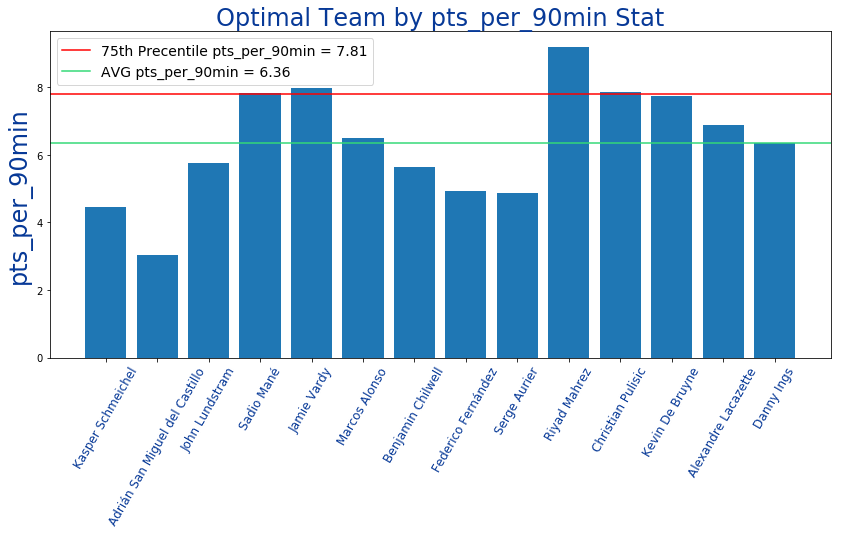

In [171]:
money_x = money_df.pts_per_90min
money_y = money_df.name
ST_75th = round(money_df.describe().pts_per_90min['75%'], 2)
ST_AVG = round(money_df.describe().pts_per_90min['mean'], 2)

plt.bar(money_y, money_x)
plt.axhline(y=ST_75th, color='r', linestyle='-', label='75th Precentile pts_per_90min = ' + str(ST_75th))
plt.axhline(y=ST_AVG, color='#33D977', linestyle='-', label='AVG pts_per_90min = ' + str(ST_AVG))
plt.ylabel('pts_per_90min', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Optimal Team by pts_per_90min Stat', fontsize = 24, color = '#073997')
plt.legend( fontsize = 14)
plt.savefig('Team_pts_per90min', bbox_inches = 'tight')
plt.show

In [172]:
top100_users = pd.read_csv('fEPL_user_data_test.csv', index_col='users')

In [173]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,formation,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,...,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,,
Matthew Troha,1,933902,920,69,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Schmeichel-LEI-start,McGovern-NOR-sub,Robertson-LIV-start,Lundstram-SHU-start,Rico-BOU-start,...,Kelly-CRY-sub,Mané-LIV-start,Pérez-LEI-start,David Silva-MCI-start,Pulisic-CHE-start,Salah-LIV-sub,Vardy-LEI-start,Abraham-CHE-start,Jiménez-WOL-start,https://fantasy.premierleague.com/entry/933902...
nick tanner,2,568651,918,68,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Rico-BOU-start,Lundstram-SHU-start,Guilbert-AVL-start,...,Dunk-BHA-sub,Maddison-LEI-start,Martial-MUN-start,McGinn-AVL-start,Mané-LIV-start,Salah-LIV-sub,Abraham-CHE-start,Rashford-MUN-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/568651...
Andrew Forey,3,4731491,914,82,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Ryan-BHA-start,Stekelenburg-EVE-sub,Tarkowski-BUR-start,Chilwell-LEI-start,Tomori-CHE-start,...,Reid-WHU-sub,De Bruyne-MCI-start,Sterling-MCI-start,Mané-LIV-start,Maddison-LEI-start,McGinn-AVL-sub,Abraham-CHE-start,Barnes-BUR-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/473149...
kurt JONKERS,4,558922,901,77,"{'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Lundstram-SHU-start,Robertson-LIV-start,Pereira-LEI-start,...,Kelly-CRY-sub,Mané-LIV-start,De Bruyne-MCI-start,Tielemans-LEI-start,Iwobi-EVE-sub,Dendoncker-WOL-sub,Firmino-LIV-start,Vardy-LEI-start,Jiménez-WOL-start,https://fantasy.premierleague.com/entry/558922...
kenneth herlihy,5,1734934,898,67,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Patrício-WOL-start,Button-BHA-sub,Söyüncü-LEI-start,Lundstram-SHU-start,Alexander-Arnold-LIV-start,...,Dunk-BHA-sub,Mount-CHE-start,Maddison-LEI-start,Mané-LIV-start,De Bruyne-MCI-start,Hudson-Odoi-CHE-sub,Rashford-MUN-start,Abraham-CHE-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/173493...


### Get Stats of top 100 players

<function matplotlib.pyplot.show(*args, **kw)>

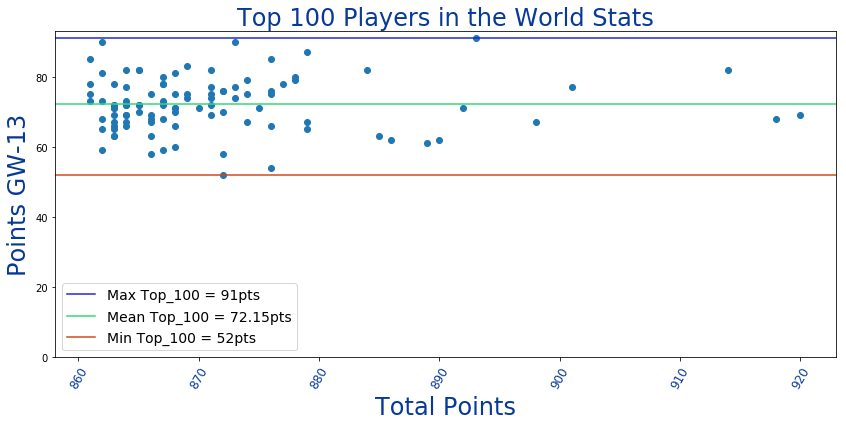

In [174]:
y =list(top100_users.game_week_points)
z =list(top100_users.total_points)

mean = np.mean(y)
maxi = np.max(y)
mini = np.min(y)

plt.scatter(z, y)
plt.ylim(bottom=0)
plt.axhline(y=maxi, color='#1D28D2', linestyle='-', label='Max Top_100 = ' + str(maxi) +'pts')
plt.axhline(y=mean, color='#33D977', linestyle='-', label='Mean Top_100 = ' + str(mean) +'pts')
plt.axhline(y=mini, color='#D2461D', linestyle='-', label='Min Top_100 = ' + str(mini) +'pts')
plt.ylabel('Points GW-'+ str(gameweek-1), fontsize = 24, color = '#073997')
plt.xlabel('Total Points', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Players in the World Stats', fontsize = 24, color = '#073997')
plt.legend(fontsize = 14)
plt.savefig('Top10_Stats', bbox_inches = 'tight')
plt.show

### Function to extract names from player string

In [175]:
def partition_names(names_list):
    clean_list = [item.partition("-")[0] for item in names_list]
    return clean_list

### Function to get the list of all selected players by position

In [176]:
def get_top100_teams(team_df):
    #create lists by position
    #GK_list
    GK_list = list(team_df.GKP_1)
    GK_list.extend(list(team_df.GKP_2))
    GK_final = partition_names(GK_list)
    
    #DF_list
    DF_list = list(team_df.DEF_1)
    DF_list.extend(list(team_df.DEF_2))
    DF_list.extend(list(team_df.DEF_3))
    DF_list.extend(list(team_df.DEF_4))
    DF_list.extend(list(team_df.DEF_5))
    DF_final = partition_names(DF_list)
    
    #MD_list
    MD_list = list(team_df.MID_1)
    MD_list.extend(list(team_df.MID_2))
    MD_list.extend(list(team_df.MID_3))
    MD_list.extend(list(team_df.MID_4))
    MD_list.extend(list(team_df.MID_5))
    MD_final = partition_names(MD_list)
    
    #ST_list
    ST_list = list(team_df.FWD_1)
    ST_list.extend(list(team_df.FWD_2))
    ST_list.extend(list(team_df.FWD_3))
    ST_final = partition_names(ST_list)
    
    return GK_final, DF_final, MD_final, ST_final

In [177]:
#get the final clean list of players per position
GK_final, DF_final, MD_final, ST_final = get_top100_teams(top100_users)[0], get_top100_teams(top100_users)[1], get_top100_teams(top100_users)[2], get_top100_teams(top100_users)[3]

In [178]:
GK_final[:3]

['Schmeichel', 'Ryan', 'Ryan']

In [179]:
MD_final[:3]

['Mané', 'Maddison', 'De Bruyne']

In [180]:
DF_final[:3]

['Robertson', 'Rico', 'Tarkowski']

In [181]:
ST_final[:3]

['Vardy', 'Abraham', 'Abraham']

### Function to get you top_n players by position ordered by # of times they were picked

In [182]:
def return_top_n(players, top_n = 10):
    ranked = Counter(players).most_common(top_n)
    return ranked

In [183]:
GK_top10 = return_top_n(GK_final)

In [184]:
GK_top10

[('Pope', 49),
 ('Ryan', 45),
 ('Button', 26),
 ('Schmeichel', 15),
 ('Heaton', 11),
 ('Gazzaniga', 11),
 ('McGovern', 9),
 ('Henderson', 7),
 ('Patrício', 5),
 ('Ramsdale', 5)]

In [185]:
DF_top10 = return_top_n(DF_final)

In [186]:
DF_top10

[('Lundstram', 94),
 ('Söyüncü', 55),
 ('Robertson', 40),
 ('Kelly', 37),
 ('Alexander', 34),
 ('Tomori', 29),
 ('Rico', 27),
 ('Dunk', 22),
 ('Chilwell', 16),
 ('Pereira', 15)]

In [187]:
MD_top10 = return_top_n(MD_final)

In [188]:
MD_top10

[('Mané', 96),
 ('De Bruyne', 78),
 ('Maddison', 46),
 ('Mount', 39),
 ('Martial', 35),
 ('Son', 22),
 ('Sterling', 21),
 ('McGinn', 19),
 ('Pulisic', 19),
 ('Dendoncker', 19)]

In [189]:
ST_top10 = return_top_n(ST_final)

In [190]:
ST_top10

[('Vardy', 99),
 ('Abraham', 93),
 ('Jiménez', 45),
 ('Rashford', 11),
 ('Aubameyang', 9),
 ('Ings', 4),
 ('Mousset', 4),
 ('Connolly', 4),
 ('Ayew', 4),
 ('Firmino', 3)]

<function matplotlib.pyplot.show(*args, **kw)>

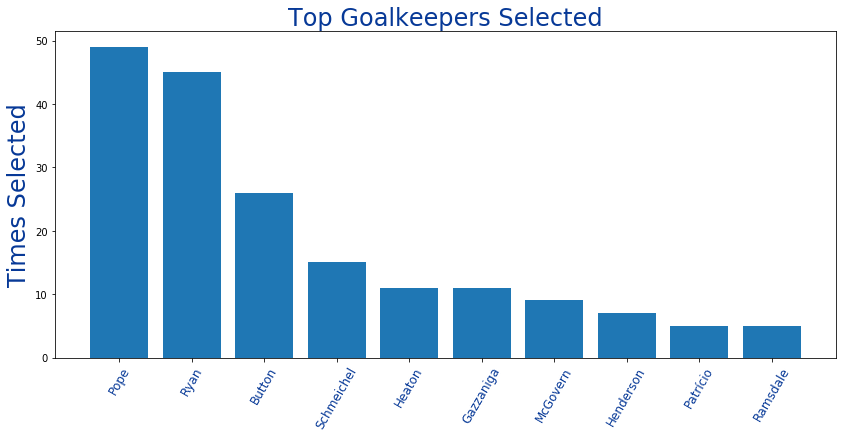

In [191]:
X = [item[0] for item in GK_top10]
Y = [item[1] for item in GK_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Goalkeepers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_GK', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

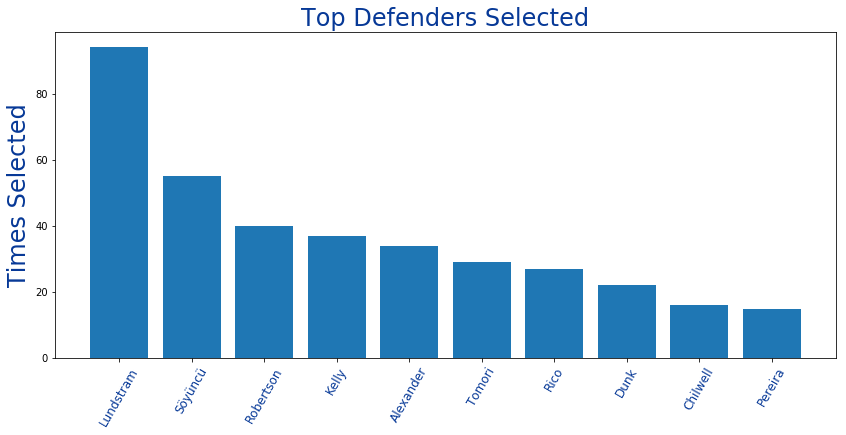

In [192]:
X = [item[0] for item in DF_top10]
Y = [item[1] for item in DF_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Defenders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_DF', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

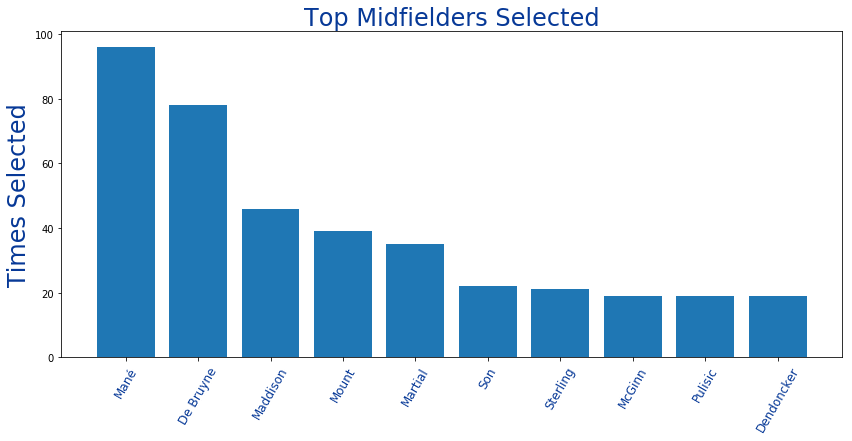

In [193]:
X = [item[0] for item in MD_top10]
Y = [item[1] for item in MD_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Midfielders Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_MD', bbox_inches = 'tight')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

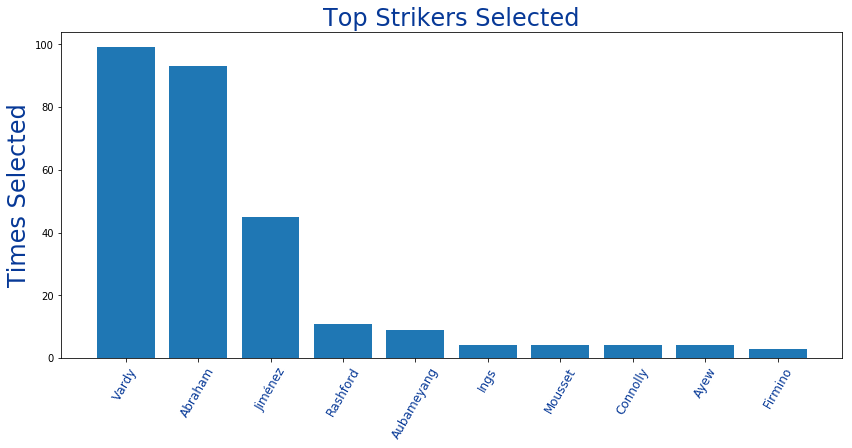

In [194]:
X = [item[0] for item in ST_top10]
Y = [item[1] for item in ST_top10]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top Strikers Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_ST', bbox_inches = 'tight')
plt.show

In [195]:
top_managers_team = GK_top10[:2]+ DF_top10[:5] + MD_top10[:5] + ST_top10[:3]

In [196]:
top_managers_team

[('Pope', 49),
 ('Ryan', 45),
 ('Lundstram', 94),
 ('Söyüncü', 55),
 ('Robertson', 40),
 ('Kelly', 37),
 ('Alexander', 34),
 ('Mané', 96),
 ('De Bruyne', 78),
 ('Maddison', 46),
 ('Mount', 39),
 ('Martial', 35),
 ('Vardy', 99),
 ('Abraham', 93),
 ('Jiménez', 45)]

<function matplotlib.pyplot.show(*args, **kw)>

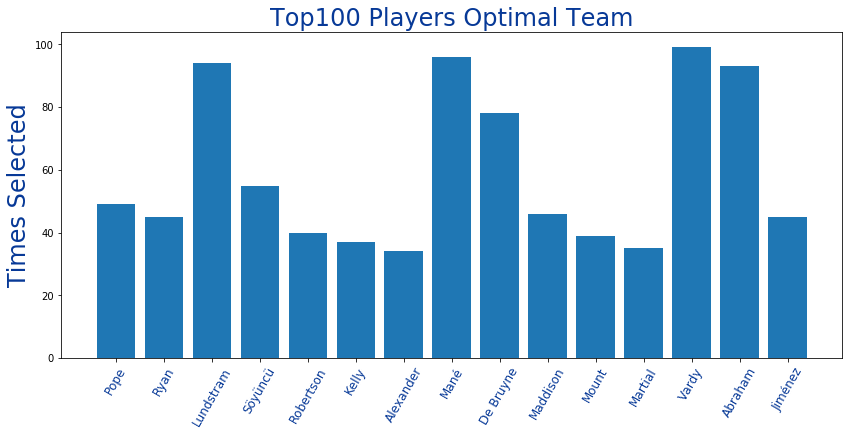

In [197]:
X = [item[0] for item in top_managers_team]
Y = [item[1] for item in top_managers_team]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top100 Players Optimal Team', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_Team', bbox_inches = 'tight')
plt.show

### Latest Injury Updates from independant site that updates faster than the Fantasy site

In [198]:
injuries = 'http://www.premierinjuries.com/?fbclid=IwAR1Uz0TTwRMOvsq1jlefIztPPg7qtPdnag3zrHxh_39wV4CZoMG0ZWq6MYU'
injuries_tab = pd.read_html(injuries)[0]

In [199]:
injuries_tab

,Player,Reason
0,Fabio Tavares,Ankle/Foot Injury
1,Tammy Abraham,Groin/Hip/Pelvic Injury
2,Hector Bellerin,Thigh Injury
3,Lys Mousset,Thigh Injury
4,Sergio Aguero,Thigh Injury
5,Todd Cantwell,Ankle/Foot Injury
6,Bukayo Saka,Knee Injury
7,Dominic Solanke,Thigh Injury
8,Ben Davies,Ankle/Foot Injury
9,Joel Ward,Knee Injury


In [200]:
top100_users.head()

,rank,user_id_num,total_points,game_week_points,formation,GKP_1,GKP_2,DEF_1,DEF_2,DEF_3,...,DEF_5,MID_1,MID_2,MID_3,MID_4,MID_5,FWD_1,FWD_2,FWD_3,user_team_pages
users,,,,,,,,,,,,,,,,,,,,,
Matthew Troha,1,933902,920,69,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Schmeichel-LEI-start,McGovern-NOR-sub,Robertson-LIV-start,Lundstram-SHU-start,Rico-BOU-start,...,Kelly-CRY-sub,Mané-LIV-start,Pérez-LEI-start,David Silva-MCI-start,Pulisic-CHE-start,Salah-LIV-sub,Vardy-LEI-start,Abraham-CHE-start,Jiménez-WOL-start,https://fantasy.premierleague.com/entry/933902...
nick tanner,2,568651,918,68,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Rico-BOU-start,Lundstram-SHU-start,Guilbert-AVL-start,...,Dunk-BHA-sub,Maddison-LEI-start,Martial-MUN-start,McGinn-AVL-start,Mané-LIV-start,Salah-LIV-sub,Abraham-CHE-start,Rashford-MUN-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/568651...
Andrew Forey,3,4731491,914,82,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Ryan-BHA-start,Stekelenburg-EVE-sub,Tarkowski-BUR-start,Chilwell-LEI-start,Tomori-CHE-start,...,Reid-WHU-sub,De Bruyne-MCI-start,Sterling-MCI-start,Mané-LIV-start,Maddison-LEI-start,McGinn-AVL-sub,Abraham-CHE-start,Barnes-BUR-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/473149...
kurt JONKERS,4,558922,901,77,"{'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3}",Ryan-BHA-start,McGovern-NOR-sub,Lundstram-SHU-start,Robertson-LIV-start,Pereira-LEI-start,...,Kelly-CRY-sub,Mané-LIV-start,De Bruyne-MCI-start,Tielemans-LEI-start,Iwobi-EVE-sub,Dendoncker-WOL-sub,Firmino-LIV-start,Vardy-LEI-start,Jiménez-WOL-start,https://fantasy.premierleague.com/entry/558922...
kenneth herlihy,5,1734934,898,67,"{'GKP': 1, 'DEF': 3, 'MID': 4, 'FWD': 3}",Patrício-WOL-start,Button-BHA-sub,Söyüncü-LEI-start,Lundstram-SHU-start,Alexander-Arnold-LIV-start,...,Dunk-BHA-sub,Mount-CHE-start,Maddison-LEI-start,Mané-LIV-start,De Bruyne-MCI-start,Hudson-Odoi-CHE-sub,Rashford-MUN-start,Abraham-CHE-start,Vardy-LEI-start,https://fantasy.premierleague.com/entry/173493...


In [201]:
test = top100_users.formation

### Extract formations as a list in a readable format

In [202]:
formations = [item.split(",")[1][8] + "-" + item.split(",")[2][8] + "-" + item.split(",")[3][8] for item in test]

In [203]:
formations[:5]

['3-4-3', '3-4-3', '3-4-3', '4-3-3', '3-4-3']

### Use top_n function to get a tuple of ranked formations by count

In [204]:
top_form = return_top_n(formations, 6)

In [205]:
top_form

[('3-4-3', 71), ('4-4-2', 11), ('4-3-3', 9), ('3-5-2', 9)]

<function matplotlib.pyplot.show(*args, **kw)>

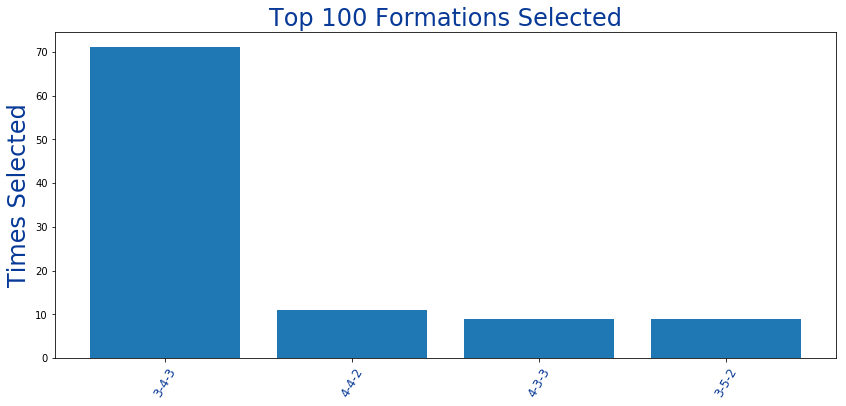

In [206]:
X = [item[0] for item in top_form]
Y = [item[1] for item in top_form]

plt.bar(X, Y)
plt.ylim(bottom=0)
# plt.axhline(y=median, color='#33D977', linestyle='-', label='Median GF = ' + str(median))
plt.ylabel('Times Selected', fontsize = 24, color = '#073997')
plt.xticks(rotation=60, fontsize = 12, color = '#073997')
plt.title('Top 100 Formations Selected', fontsize = 24, color = '#073997')
# plt.legend(fontsize = 14)
plt.savefig('Top100_Forma', bbox_inches = 'tight')
plt.show